In [1]:
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,torch,geomloss,seaborn

Python implementation: CPython
Python version       : 3.7.4
IPython version      : 7.8.0

numpy   : 1.19.0
scipy   : 1.2.1
torch   : 1.8.1
geomloss: 0.2.3
seaborn : 0.11.1

Compiler    : Clang 10.0.1 (clang-1001.0.46.4)
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import sys
import importlib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import torch
from IPython.display import HTML

sys.path.append('../')
sys.path.append('../cpflow')

outdir = '../out/pdes_1D/'

In [3]:
# Debug: reload everything
import src.flow
import src.utils
import src.pde
import src.callbacks
import src.functionals
import cpflow.lib.logdet_estimators

importlib.reload(src.flow)
importlib.reload(src.utils)
importlib.reload(src.pde)
importlib.reload(src.callbacks)
importlib.reload(src.functionals)
importlib.reload(cpflow.lib.logdet_estimators)

No rdkit
tsnecuda not found - will use (slower) cpu implementation
No rdkit
tsnecuda not found - will use (slower) cpu implementation


<module 'cpflow.lib.logdet_estimators' from '../cpflow/lib/logdet_estimators.py'>

# 1. Porous Medium Equation

### Function Definition 

In [29]:
import src.pde
importlib.reload(src.pde)

from src.pde import BarenblattProfile
from src.utils import density_plot_1d

C = (3/16)**(1/3)
t0 = 1e-3
m = 2.0

ρ0 = BarenblattProfile(m, t0, C)

### Debugging Barenblatt

In [30]:
# Check that value of C satisfies integral constriaint

x = torch.linspace(*ρ0.domain,1000)

integral = torch.trapz(torch.exp(ρ0.log_prob(x)), x).item()#, *, dim=-1)

print(f'For Carillo et al. paper, M = 2, here ∫ρ(x,t=0) = {integral:4.4e}')

For Carillo et al. paper, M = 2, here ∫ρ(x,t=0) = 2.0000e+00


In [37]:

t = 1e-1

x = torch.linspace(*ρ0.get_domain(t, 1e-4),100)

print(ρ0.log_prob_asymptotic(x, t))

integral = torch.trapz(torch.exp(ρ0.log_prob_asymptotic(x, t)), x).item()#, *, dim=-1)

print(f'For Carillo et al. paper, M = 2, here ∫ρ(x,t->infty) = {integral:4.4e}')

tensor([-0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992, -0.1992,
        -0.1992, -0.1992, -0.1992, -0.19

In [6]:
# Sanity check: domain evolution after manual updates

for i in range(10):
    print(ρ0.domain)
    x = torch.linspace(*ρ0.domain, 100)
    ρ0.step(1e-2)

ρ0.reset()    

(-0.2620731394208898, 0.2620731394208898)
(-0.5828466683251458, 0.5828466683251458)
(-0.723041679252569, 0.723041679252569)
(-0.8232736310689074, 0.8232736310689074)
(-0.9036875658095792, 0.9036875658095792)
(-0.9718825403832452, 0.9718825403832452)
(-1.0316531115942587, 1.0316531115942587)
(-1.0852002481787397, 1.0852002481787397)
(-1.133927944905386, 1.133927944905386)
(-1.1787931334361073, 1.1787931334361073)


In [188]:
### Check that diffusion term is correct
ρ0.reset()    
eps = 1e-4
t1 = 1e-3
t2 = t1 + eps

x = torch.linspace(*ρ0.domain,100)

ρt1_x = ρ0.log_prob(x, t1)
ρt2_x = ρ0.log_prob(x, t2)

delta_ρ = (torch.exp(ρt2_x)-torch.exp(ρt1_x))/eps

print(delta_ρ)

print(ρ0.diffusion_value(x, t1))
print(ρ0.partial_t(x, t1))

print(ρ0.diffusion_value(x, 0.5*(t2 + t1)))
print(ρ0.partial_t(x, 0.5*(t1 + t2)))

print(ρ0.diffusion_value(x, t2))
print(ρ0.partial_t(x, t2))


tensor([ 629.9043,  575.4006,  522.0103,  469.7252,  418.5605,  368.5069,
         319.5644,  271.7328,  225.0147,  179.4100,  134.9163,   91.5337,
          49.2668,    8.1110,  -31.9314,  -70.8628, -108.6855, -145.3876,
        -180.9931, -215.4636, -248.8351, -281.0979, -312.2378, -342.2761,
        -371.1939, -398.9983, -425.7035, -451.2835, -475.7476, -499.1102,
        -521.3547, -542.4976, -562.5105, -581.4219, -599.2222, -615.9067,
        -631.4897, -645.9332, -659.2894, -671.5155, -682.6544, -692.6632,
        -701.5562, -709.3477, -716.0187, -721.5881, -726.0228, -729.3654,
        -731.5874, -732.7080, -732.7080, -731.5874, -729.3654, -726.0228,
        -721.5881, -716.0187, -709.3477, -701.5562, -692.6632, -682.6544,
        -671.5155, -659.2894, -645.9332, -631.4897, -615.9067, -599.2222,
        -581.4219, -562.5105, -542.4976, -521.3547, -499.1102, -475.7476,
        -451.2835, -425.7035, -398.9983, -371.1939, -342.2761, -312.2378,
        -281.0979, -248.8351, -215.463

../src/pde.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C, κ, α, β, d, m = self.C, self.κ, self.α, self.β, self.d, self.m


In [38]:
ρ0.reset()
X = ρ0.sample((1000,))
print(X.shape)
print(torch.mean(X))
print(torch.var(X))
print(ρ0.m, ρ0.t0, ρ0.t, ρ0.C, ρ0.d, ρ0.α, ρ0.β, ρ0.κ)


torch.Size([1000, 1])
tensor(0.0009)
tensor(0.0146)
tensor(2., dtype=torch.float64) tensor(0.0010, dtype=torch.float64) tensor(0.0010, dtype=torch.float64) tensor(0.5724, dtype=torch.float64) tensor(1, dtype=torch.int32) tensor(0.3333, dtype=torch.float64) tensor(0.3333, dtype=torch.float64) tensor(0.0833, dtype=torch.float64)


In [9]:
### animation
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

def animate_1d_pde(ρ, steps, xmin,xmax, ρ_inf=None, *args, **kwargs):
    ρ.reset()
    fig, ax = plt.subplots()
    ax.set_xlim(xmin,xmax)
    _x = torch.linspace(xmin, xmax, 100)
    y = torch.exp(ρ.log_prob(_x))
    
    # ax.plot(sim.grid[0]/nm, steady, color='k', ls='--', alpha=.5)
    line, = ax.plot(_x,y, lw=2, color='C3', ls='--', alpha=0.5)
    line, = ax.plot(_x,y, lw=2, color='C3')
    if ρ_inf is not None:
        yinf = torch.exp(ρinf.log_prob(_x))
        line, = ax.plot(_x,yinf, lw=2, color='C2')
        
    ax.set(xlabel='x', ylabel='normalized PDF')
    # ax.margins(x=0)
    #plt.show()

    def update(i):
        ρ.step(1e-3)
        y = torch.exp(ρ.log_prob(_x))
        #line, = ax.plot(_x, y, lw=2, color='red')
        line.set_ydata(y)
        return [line]

    anim = FuncAnimation(fig, update, frames=range(steps), *args, **kwargs)
    plt.close()
    ρ.reset()
    return anim

anim = animate_1d_pde(ρ0, 10, -1,1, interval=30)

save_path = os.path.join(outdir, 'Barenblatt_PME')
save_path = None
if save_path:
    anim.save(save_path +'.mp4')
HTML(anim.to_html5_video())

##### Asymptotic Solution

In [40]:
# Finding steady state solution
t = 1e12
print(torch.exp(ρ0.log_prob(torch.tensor(0), t)))
print(torch.exp(ρ0.log_prob(torch.tensor(1), t)))
print(t**(-ρ0.α)*C**(1/(m-1)))        

ρ_asymp = lambda x,t: t**(-ρ0.α)*C**(1/(m-1))

t_grid = torch.linspace(0,1,10)

### First Attempt
# We add initial time here so that it can be called with relative time inside FunctionalValue Callback
F_asymp = lambda t: (t+t0)**(-ρ0.α*m) * C**(m/(m-1)) * 2*ρ0.get_domain(t=t+t0)[1] # Not normalized
print([F_asymp(t).item() for t in t_grid])

### Second Attempt - This one is correct I think!
F_asymp = lambda t: (t+t0)**(-ρ0.β*m) * C**(-m/2.) * ρ0.κ**(m/2.) *2*ρ0.get_domain(t=t+t0)[1]
print([F_asymp(t).item() for t in t_grid])


tensor([5.7236e-05], dtype=torch.float64)
tensor([5.7236e-05], dtype=torch.float64)
tensor(5.7236e-05, dtype=torch.float64)
[21.633677522304527, 3.571554793950797, 2.834801601999875, 2.476436698849121, 2.2499951129691897, 2.08871174201199, 1.9655537699275465, 1.8671078995763228, 1.785824727772975, 1.7170701111205757]
[9.614967787690901, 1.587357686200354, 1.2599118231110555, 1.1006385328218313, 0.9999978279863064, 0.9283163297831066, 0.8735794533011316, 0.8298257331450322, 0.793699879010211, 0.7631422716091447]


In [41]:
from functools import partial
t = 1e0
ρ0.t = torch.tensor(t)
x = torch.linspace(*ρ0.get_domain(t),100)
ρat = partial(ρ0.log_prob_asymptotic, t = t)
print(f'F(ρ0) with domain ({x.min().item():6.2f},{x.max().item():6.2f}) = {F.exact_eval(x,ρ=ρ0).item():4.2f}')
print(f'F(ρ_asympt) with domain ({x.min().item():6.2f},{x.max().item():6.2f}) by intergration = {F.exact_eval(x,ρ=ρat).item():4.2f}')
print(f'F(ρ_asympt) with domain ({x.min().item():6.2f},{x.max().item():6.2f}) analytic = {F_asymp(t):4.2f}')

ρ0.reset()

F(ρ0) with domain ( -2.62,  2.62) = 0.92
F(ρ_asympt) with domain ( -2.62,  2.62) by intergration = 0.75
F(ρ_asympt) with domain ( -2.62,  2.62) analytic = 0.76


In [23]:
print(ρ0.get_domain(), ρ0.log_prob(torch.tensor(0.5)))

(-0.2620731394208898, 0.2620731394208898) tensor([-inf])


In [179]:
# Wrapper for aysmptotic distriv
import copy
from src.pde import rejection_sampler
class AsymptoticBarenblatt:
    def __init__(self, ρ0): self.ρ = ρ0
    def log_prob(self, x, t=None): return self.ρ.log_prob_asymptotic(x, t)
    def sample(self, sample_size=None): return rejection_sampler(self, sample_size, -1, 1)
        #proposal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

ρasymp = AsymptoticBarenblatt(ρ0)

print(ρasymp.log_prob(x))
ρasymp.sample((1000,))
ρ0.step(1e-3)
print(ρasymp.log_prob(x))

_ρ0 = copy.deepcopy(ρ0)
_ρ0.step(1e2)
ρasymp_inf = AsymptoticBarenblatt(_ρ0)
print(ρasymp_inf.log_prob(x))



tensor([  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf, 0.8026, 0.8026, 0.8026,
        0.8026, 0.8026, 0.8026, 0.8026, 0.8026, 0.8026, 0.8026, 0.8026, 0.8026,
        0.8026, 0.8026, 0.8026, 0.8026,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf])
tensor([  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,

No rdkit
tsnecuda not found - will use (slower) cpu implementation


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[0.0,1.0] to balance them.
   0   2.99e-01       0.05     0.00     0.55   5.47e-01
 100   4.88e-02      -1.65     0.00     0.00   5.49e-04
 200   5.07e-02      -1.65     0.00     0.00   1.12e-04
 300   5.09e-02      -1.65     0.00     0.00   6.90e-05
 400   5.11e-02      -1.65     0.00     0.00   1.28e-05
Updating cache with: 1.73e+00  0.00e+00  1.05e+00  1.98e+00  

---> After JKO Step: 1, F(ρ)=-1.6549e+00 <---

------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   6.75e-01      -0.57     0.00     0.04   6.66e-01
 100   1.77e-02      -0.33     0.00     0.00   2.57e-04
 200   1.59e-02      -0.33     0.00     0.00   8.65e

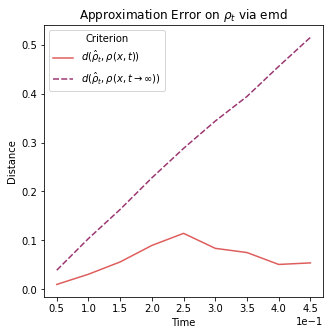

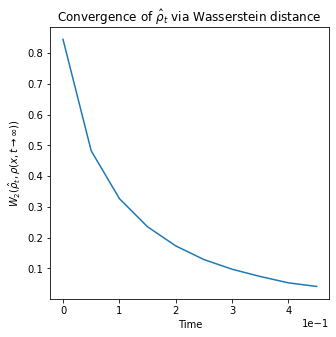

In [201]:
import importlib

import src.flow
import src.utils
import src.pde
import src.callbacks
import src.functionals
import cpflow.lib.logdet_estimators
%matplotlib inline

importlib.reload(src.flow)
importlib.reload(src.utils)
importlib.reload(src.pde)
importlib.reload(src.callbacks)
importlib.reload(src.functionals)
importlib.reload(cpflow.lib.logdet_estimators)

from src.flow import GradFlow
from src.utils import infer_input_type, invert_potential
from src.callbacks import CallbackList, PlottingCallback, ConvergenceCallback, DistributionalDistanceCallback
from src.callbacks import FunctionalValueCallback, EstimateEntropyCallback
from src.functionals import Functional, InternalEnergyFunctional, EntropyFunctional
from cpflow.lib.logdet_estimators import unbiased_logdet
from lib.icnn import ICNN, ICNN2, ICNN3, DenseICNN2, ResICNN2

from src.icnn import FICNN


f = lambda x: torch.pow(x, m)
multfun = lambda logr: torch.exp((m-1)*logr)

ρ0.reset()

F = InternalEnergyFunctional(f, ρ0, X, multfun)

cb1 = PlottingCallback(animate=True, show_density=True, 
                       density_method='kde', use_sns=True,
                       show_trajectories=False, plot_pad=0.5)


save_path = None
save_path = os.path.join(outdir, 'porousmedia')

cb1 = PlottingCallback(animate=True, display_freq=1, same_fig=True,
                       ρ0=ρ0, 
                       show_density=True,
                       density_method='kde',  use_sns=True, density_bw=0.5,
                       figsize=(5,5), xrng=(-1,1), yrng=(0,6), 
                       show_trajectories=False, plot_pad=0.5, save_path=save_path)

cb2 = FunctionalValueCallback(F, ρ0=ρ0, ρinf=None, F_asymp = F_asymp, integral_domain=(-2.0,2.0),
                              plot_F_obj=False, plot_F_estim=True,  plot_F_exact=True)

cb3 = DistributionalDistanceCallback(ρ0=ρ0, ρinf=None, ρasymp=ρasymp, criterion='emd')

cb4 = ConvergenceCallback(distance='Wasserstein', ρ_target=ρasymp_inf, figsize=(4,4))#, modality='to-target')


cb = CallbackList([cb3, cb4]) 


factory = lambda: FICNN(input_dim=1, hidden_dims=[100,20], nonlin='leaky_relu', dropout=0)

gf = GradFlow(X, F=F, ρ0=ρ0, τ=5e-2, lr = 1e-3, strongify_icnn=None, convex_net = factory,# ResICNN2(dim=1, dimh=5),
              callbacks=cb, optimizer = 'adam', opt_iters=400)

XT = gf.flow(steps=10)
plt.show()

In [118]:
# from IPython.display import HTML
# HTML(cb1.animation.to_html5_video())

#### Averaging Across Multiple Restarts

------------- FLOW WITH RANDOM RESTART # 1 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   7.86e-01      -0.45     0.01     0.89   8.86e-01
 100   4.97e-02      -1.72     0.01     0.01   1.08e-03
 200   5.12e-02      -1.72     0.01     0.01   1.52e-04
 300   5.15e-02      -1.72     0.01     0.01   1.10e-04
 400   5.18e-02      -1.72     0.01     0.01   9.02e-05
 500   5.17e-02      -1.72     0.01     0.01   1.26e-05
 600   5.18e-02      -1.72     0.01     0.01   2.86e-06
 700   5.17e-02      -1.72     0.01     0.01   1.16e-06
 800   5.17e-02      -1.72     0.01     0.01   1.09e-06
 900   5.17e-02      -1.72     0.01     0.01   1.08e-07
1000   5.17e-02      -1.72     0.01     0.01   0.00e+00
Updating cache with: 1.74e+00  0.00e+00  1.12e+00  1.86e+00  

---> After JKO Step: 1, F(ρ)=-1.7211e

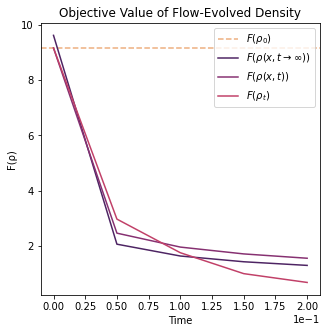

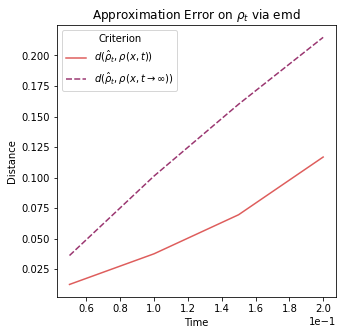

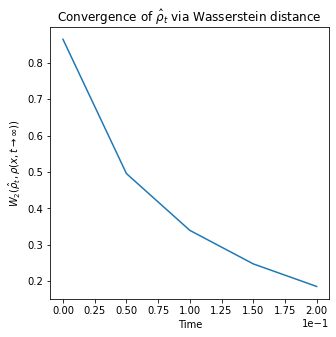

------------- FLOW WITH RANDOM RESTART # 2 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   7.32e-02       5.87     0.00     0.26   2.65e-01
 100   4.89e-02      -1.67     0.00     0.00   2.98e-04
 200   5.10e-02      -1.67     0.00     0.00   6.66e-05
 300   5.13e-02      -1.67     0.00     0.00   9.54e-06
 400   5.13e-02      -1.67     0.00     0.00   1.43e-06
 500   5.13e-02      -1.67     0.00     0.00   6.31e-08
 600   5.13e-02      -1.67     0.00     0.00   0.00e+00
 700   5.13e-02      -1.67     0.00     0.00   0.00e+00
 800   5.13e-02      -1.67     0.00     0.00   0.00e+00
 900   5.13e-02      -1.67     0.00     0.00   0.00e+00
1000   5.13e-02      -1.67     0.00     0.00   2.68e-09
Updating cache with: 1.65e+00  0.00e+00  1.07e+00  1.78e+00  

---> After JKO Step: 1, F(ρ)=-1.6698e+00 <---

Density BW: 0.5
Exact query ranges: tensor(-0.9719) tensor(0.9719)
inversion error 0.016017794609069824
F(ρₜ)=

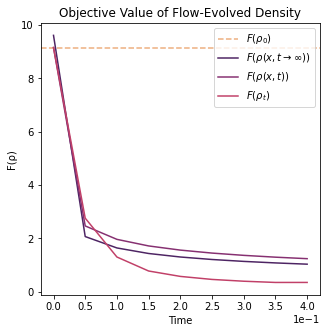

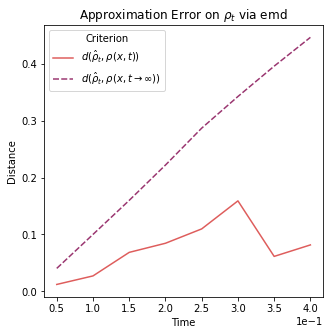

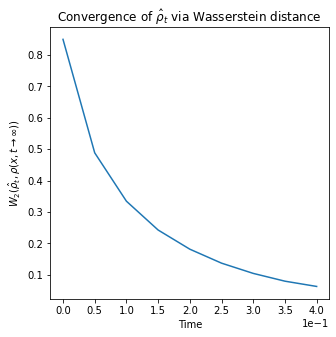

------------- FLOW WITH RANDOM RESTART # 3 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   1.08e-02       0.63     0.00     0.08   8.57e-02
 100   4.80e-02      -1.62     0.00     0.00   1.06e-04
 200   5.03e-02      -1.62     0.00     0.00   6.08e-05
 300   5.07e-02      -1.62     0.00     0.00   5.85e-06
 400   5.07e-02      -1.62     0.00     0.00   8.26e-07
 500   5.07e-02      -1.62     0.00     0.00   1.03e-07
 600   5.07e-02      -1.62     0.00     0.00   5.06e-07
 700   5.07e-02      -1.62     0.00     0.00   3.73e-11
 800   5.07e-02      -1.62     0.00     0.00   2.76e-09
 900   5.07e-02      -1.62     0.00     0.00   2.98e-09
1000   5.07e-02      -1.62     0.00     0.00   8.12e-09
Updating cache with: 1.04e+00  0.00e+00  1.03e+00  1.01e+00  

---> After JKO Step: 1, F(ρ)=-1.6219e+00 <---

Density BW: 0.5
Exact query ranges: tensor(-0.9719) tensor(0.9719)
inversion error 0.07123416662216187
F(ρₜ)= 

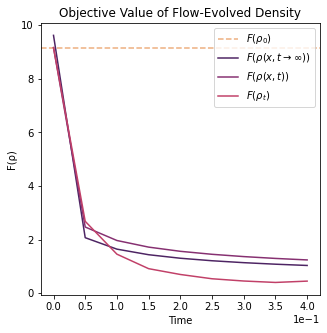

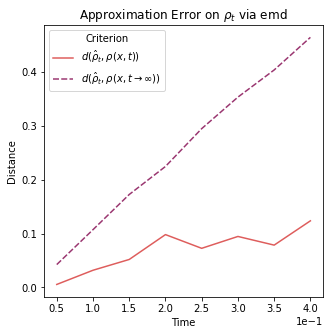

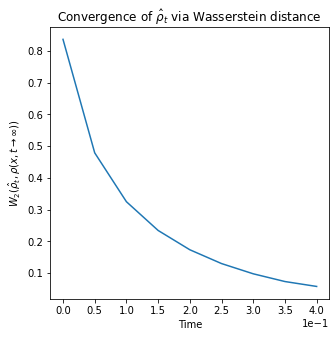

------------- FLOW WITH RANDOM RESTART # 4 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   5.95e-01       2.30     0.00     0.77   7.71e-01
 100   5.11e-02      -1.69     0.00     0.00   1.11e-03
 200   5.09e-02      -1.69     0.00     0.00   7.60e-05
 300   5.09e-02      -1.69     0.00     0.00   7.16e-05
 400   5.16e-02      -1.69     0.00     0.00   7.27e-05
 500   5.17e-02      -1.69     0.00     0.00   2.49e-05
 600   5.15e-02      -1.69     0.00     0.00   6.62e-06
 700   5.15e-02      -1.69     0.00     0.00   2.41e-06
 800   5.15e-02      -1.69     0.00     0.00   3.11e-07
 900   5.15e-02      -1.69     0.00     0.00   2.11e-07
1000   5.15e-02      -1.69     0.00     0.00   2.25e-07
Updating cache with: 1.59e+00  0.00e+00  1.09e+00  1.66e+00  

---> After JKO Step: 1, F(ρ)=-1.6894e+00 <---

Density BW: 0.5
Exact query ranges: tensor(-0.9719) tensor(0.9719)
inversion error 0.011436939239501953
F(ρₜ)=

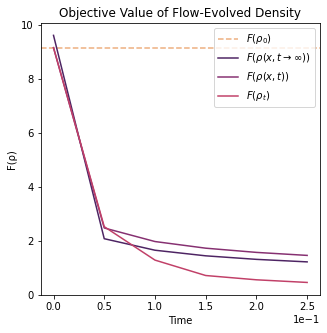

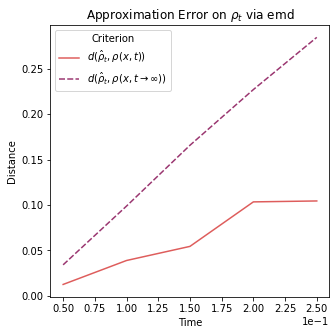

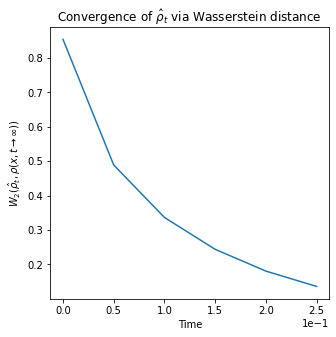

------------- FLOW WITH RANDOM RESTART # 5 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-3.0,-2.0] to balance them.
   0   1.10e-01      18.75     0.01     0.33   3.23e-01
 100   4.33e-02      -1.67     0.01     0.01   1.04e-03
 200   4.96e-02      -1.66     0.01     0.01   7.21e-05
 300   5.06e-02      -1.66     0.01     0.01   7.90e-05
 400   5.11e-02      -1.66     0.01     0.01   1.61e-05
 500   5.12e-02      -1.66     0.01     0.01   1.74e-06
 600   5.12e-02      -1.66     0.01     0.01   1.79e-07
 700   5.12e-02      -1.66     0.01     0.01   2.88e-07
 800   5.12e-02      -1.66     0.01     0.01   2.47e-07
 900   5.12e-02      -1.66     0.01     0.01   1.46e-08
1000   5.12e-02      -1.66     0.01     0.01   0.00e+00
Updating cache with: 1.72e+00  0.00e+00  1.06e+00  1.92e+00  

---> After JKO Step: 1, F(ρ)=-1.6645e

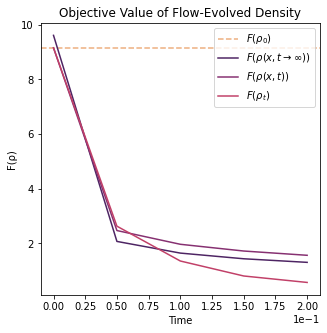

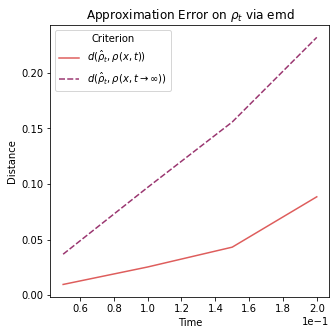

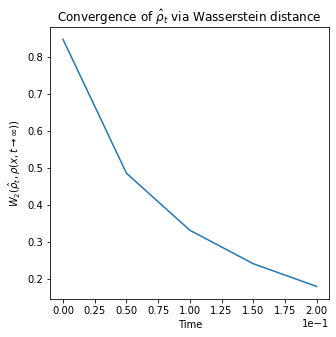

------------- FLOW WITH RANDOM RESTART # 6 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[0.0,1.0] to balance them.
   0   1.18e-01      -0.03     0.01     0.35   3.37e-01
 100   4.85e-02      -1.62     0.01     0.01   4.43e-04
 200   4.94e-02      -1.62     0.01     0.01   9.69e-05
 300   4.99e-02      -1.62     0.01     0.01   7.84e-05
 400   5.06e-02      -1.62     0.01     0.01   3.14e-05
 500   5.06e-02      -1.62     0.01     0.01   8.09e-06
 600   5.06e-02      -1.62     0.01     0.01   1.21e-06
 700   5.06e-02      -1.62     0.01     0.01   4.55e-08
 800   5.06e-02      -1.62     0.01     0.01   0.00e+00
 900   5.06e-02      -1.62     0.01     0.01   0.00e+00
1000   5.06e-02      -1.62     0.01     0.01   0.00e+00
Updating cache with: 1.38e+00  0.00e+00  1.03e+00  1.41e+00  

---> After JKO Step: 1, F(ρ)=-1.6236e+0

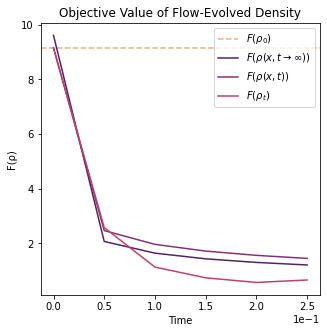

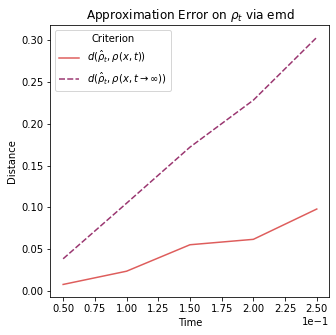

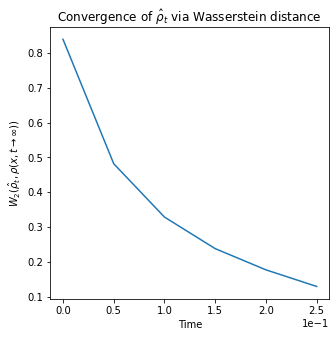

------------- FLOW WITH RANDOM RESTART # 7 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   5.47e-01      20.72     0.01     0.74   7.35e-01
 100   3.95e-02      -1.66     0.01     0.01   1.09e-03
 200   5.01e-02      -1.67     0.01     0.01   2.33e-04
 300   5.01e-02      -1.67     0.01     0.01   1.13e-04
 400   5.12e-02      -1.67     0.01     0.01   4.64e-05
 500   5.13e-02      -1.67     0.01     0.01   2.00e-06
 600   5.13e-02      -1.67     0.01     0.01   1.47e-06
 700   5.13e-02      -1.67     0.01     0.01   7.19e-07
 800   5.13e-02      -1.67     0.01     0.01   2.73e-07
 900   5.13e-02      -1.67     0.01     0.01   6.11e-08
1000   5.13e-02      -1.67     0.01     0.01   0.00e+00
Updating cache with: 1.53e+00  0.00e+00  1.07e+00  1.59e+00  

---> After JKO Step: 1, F(ρ)=-1.6709e+00 <---

Density BW: 0.5
Exact query ranges: tensor(-0.9719) tensor(0.9719)
inversion error 0.08731776475906372
F(ρₜ)= 

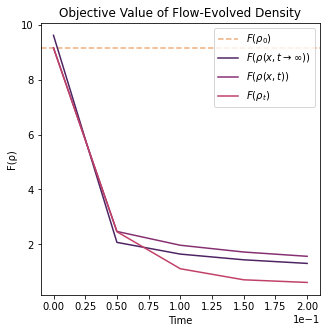

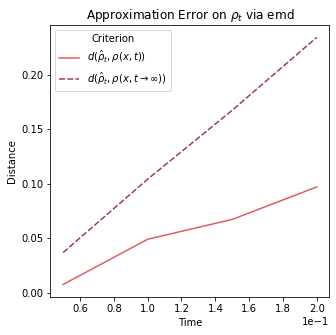

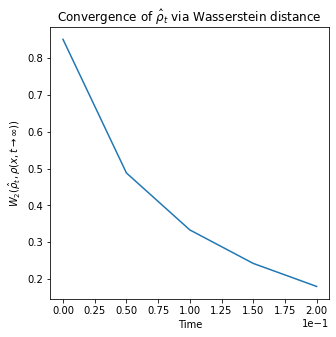

------------- FLOW WITH RANDOM RESTART # 8 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   4.67e-01      18.72     0.00     0.68   6.79e-01
 100   4.83e-02      -1.72     0.00     0.00   3.16e-03
 200   4.95e-02      -1.71     0.00     0.00   1.48e-04
 300   5.03e-02      -1.71     0.00     0.00   7.33e-05
 400   5.15e-02      -1.71     0.00     0.00   5.86e-05
 500   5.17e-02      -1.71     0.00     0.00   1.10e-05
 600   5.17e-02      -1.71     0.00     0.00   1.02e-06
 700   5.17e-02      -1.71     0.00     0.00   1.73e-06
 800   5.17e-02      -1.71     0.00     0.00   3.06e-07
 900   5.17e-02      -1.71     0.00     0.00   1.20e-07
1000   5.17e-02      -1.71     0.00     0.00   0.00e+00
Updating cache with: 1.72e+00  0.00e+00  1.11e+00  1.84e+00  

---> After JKO Step: 1, F(ρ)=-1.7119e+00 <---

Density BW: 0.5
Exact query ranges: tensor(-0.9719) tensor(0.9719)
inversion error 0.05098670721054077
F(ρₜ)= 

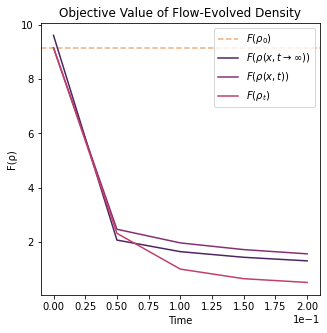

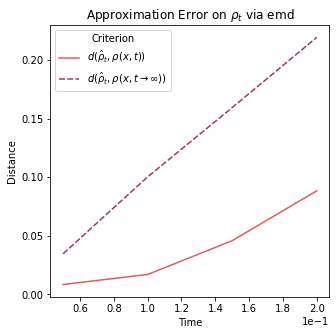

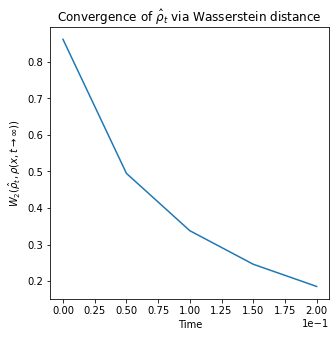

------------- FLOW WITH RANDOM RESTART # 9 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0   9.62e-01       3.59     0.00     0.98   9.80e-01
 100   3.86e-02      -1.70     0.00     0.00   5.06e-04
 200   4.74e-02      -1.69     0.00     0.00   1.84e-04
 300   5.15e-02      -1.69     0.00     0.00   6.81e-05
 400   5.15e-02      -1.69     0.00     0.00   1.89e-05
 500   5.15e-02      -1.69     0.00     0.00   1.59e-06
 600   5.16e-02      -1.69     0.00     0.00   1.93e-07
 700   5.16e-02      -1.69     0.00     0.00   1.86e-07
 800   5.16e-02      -1.69     0.00     0.00   3.31e-08
 900   5.16e-02      -1.69     0.00     0.00   0.00e+00
1000   5.16e-02      -1.69     0.00     0.00   0.00e+00
Updating cache with: 1.62e+00  0.00e+00  1.09e+00  1.70e+00  

---> After JKO Step: 1, F(ρ)=-1.6942e+00 <---

Density BW: 0.5
Exact query ranges: tensor(-0.9719) tensor(0.9719)
inversion error 0.12372380495071411
F(ρₜ)= 

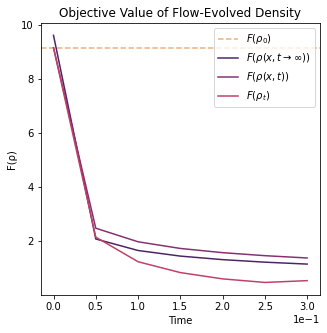

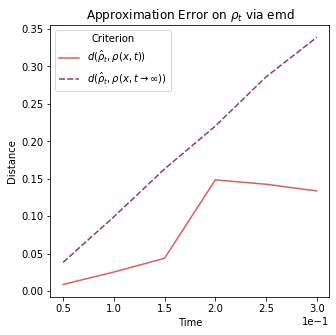

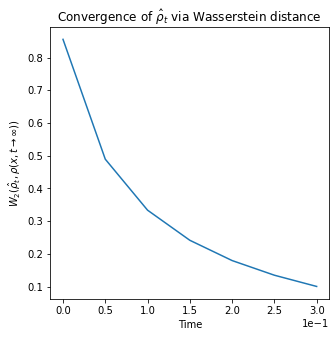

------------- FLOW WITH RANDOM RESTART # 10 -------------
here
Density BW: 0.5
Exact query ranges: tensor(-0.2621) tensor(0.2621)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=ℱ(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-3.0,-2.0] to balance them.
   0   5.50e-04       0.11     0.01     0.03   2.05e-02
 100   5.25e-02      -1.70     0.01     0.01   3.74e-04
 200   5.17e-02      -1.70     0.01     0.01   5.87e-05
 300   5.15e-02      -1.70     0.01     0.01   1.86e-05
 400   5.16e-02      -1.70     0.01     0.01   2.00e-06
 500   5.16e-02      -1.70     0.01     0.01   5.94e-07
 600   5.16e-02      -1.70     0.01     0.01   2.55e-07
 700   5.16e-02      -1.70     0.01     0.01   3.88e-07
 800   5.16e-02      -1.70     0.01     0.01   2.40e-07
 900   5.16e-02      -1.70     0.01     0.01   2.04e-08
1000   5.16e-02      -1.70     0.01     0.01   5.59e-09
Updating cache with: 1.74e+00  0.00e+00  1.10e+00  1.91e+00  

---> After JKO Step: 1, F(ρ)=-1.6973e

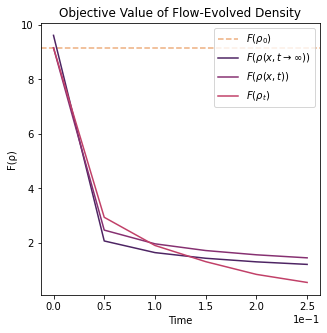

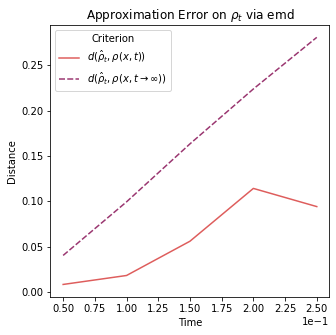

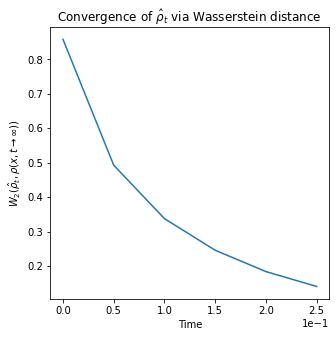

Done with loops, completed 10 succesful ones
> /Users/daalvare/workspace/GFICNN/src/flow.py(562)flow_repeatedly()
-> X_joint_hist  = torch.cat(X_joint_hist, dim = -1)  # n x d x t x reps
(Pdb) c


RuntimeError: Sizes of tensors must match except in dimension 3. Got 6 and 10 in dimension 2 (The offending index is 1)

In [202]:
cb = CallbackList([cb1, cb2, cb3, cb4]) 

gf = GradFlow(X, F=F, ρ0=ρ0, τ=5e-2, lr = 1e-3, strongify_icnn=None, convex_net = factory,
              callbacks=cb, optimizer = 'adam', opt_iters=1000)

XT = gf.flow_repeatedly(samples=200, steps=10, repetitions=10)
#XT = gf.flow_repeatedly(samples=200, steps=10, repetitions=5) # DEBUG

exp_name = f'pme_τ{gf.τ}_it{gf.opt_iters}_str{gf.strongify_icnn}'

In [130]:
F_estim_hist_bkup = cb2.F_estim_hist.copy()
times_bkup = cb2.times.copy()
cb3_bkup = cb3.stack_errors

In [78]:
print(cb2.times[0])
print(cb2.F_asymp_hist)
print(cb2.F_estim_hist)
print(cb2.F_exact_hist)

print(cb2.F_estim_hist.max())

mask = cb2.F_estim_hist[:,1:].max(axis=1) < cb2.F_estim_hist[:,0]
print(mask)

# F CB
cb2.F_estim_hist = cb2.F_estim_hist[mask,:]
cb2.times = cb2.times[mask,:]
cb2.F_exact_hist = cb2.F_exact_hist[mask,:]
print(cb2.times.shape)
print(cb2.F_estim_hist.shape)
print(cb2.F_exact_hist.shape)

# Conv CBACK
print(stack_mask)
stack_mask = np.repeat(mask, len(gf.f_hist))
se = [e for i,e in enumerate(cb3.stack_errors) if i in np.where(stack_mask)[0]]
cb3.stack_errors = se


#print(cb2.F_asymp_hist.shape)


[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011
 0.012 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]
[9.61496802 6.9335944  5.82385577 5.17870929 4.74251445 4.42116586
 4.17096265 3.96849535 3.79993982 3.65653143 3.53240422 3.42346119
 3.32674043 3.24003885 3.16167815 3.09035356 3.02503276 2.96488648
 2.90923954 2.85753568 2.80931173]
[[9.15784   7.487565  6.365587  5.540691  4.9422646 4.487528  4.0981736
  3.771937  3.5084832 3.2844696 3.1050463 2.9454126 2.80149   2.6818378
  2.5678444 2.4704134 2.3766763 2.333708  2.2532496 2.2097356 2.139732 ]
 [9.15784   7.334497  6.273617  5.5098014 4.9141784 4.4303446 4.0430746
  3.7032642 3.410736  3.1003056 2.8689625 2.6903255 2.5437155 2.4374492
  2.3404179 2.2468367 2.2252932 2.1471403 2.0697405 2.000882  1.941431 ]
 [9.15784   7.090784  5.8535557 4.9418235 4.282994  3.793477  3.417467
  3.1233048 2.8834538 2.7259386 2.6088545 2.460763  2.3462713 2.2423797
  2.138724  2.054129  1.9702468 1.8990537 1.8318883 1.7710

In [187]:
dists = cb4.dists
times = cb4.times
stack_dists = cb4.stack_dists
stack_times = cb4.stack_times

In [188]:
stack_dists

[{'Time': 0.1, 'Distance': 0.3581077491232752},
 {'Time': 0.2, 'Distance': 0.20255461561397198},
 {'Time': 0.30000000000000004, 'Distance': 0.11577893093982691},
 {'Time': 0.1, 'Distance': 0.362835161741696},
 {'Time': 0.2, 'Distance': 0.1950549214201825},
 {'Time': 0.30000000000000004, 'Distance': 0.11296945298392844},
 {'Time': 0.1, 'Distance': 0.35778914110026344},
 {'Time': 0.2, 'Distance': 0.19597247636602355},
 {'Time': 0.30000000000000004, 'Distance': 0.11313261635854882},
 {'Time': 0.4, 'Distance': 0.06640260070438869},
 {'Time': 0.5, 'Distance': 0.03701780237308885},
 {'Time': 0.1, 'Distance': 0.35245370910224183},
 {'Time': 0.2, 'Distance': 0.19239904568751787},
 {'Time': 0.30000000000000004, 'Distance': 0.11087131553197081},
 {'Time': 0.4, 'Distance': 0.06811408520527511},
 {'Time': 0.1, 'Distance': 0.35550383470793934},
 {'Time': 0.2, 'Distance': 0.19097195081855656},
 {'Time': 0.30000000000000004, 'Distance': 0.10784553529807364},
 {'Time': 0.1, 'Distance': 0.3537895646385

In [214]:
importlib.reload(src.callbacks)
from src.callbacks import ConvergenceCallback #, DistributionalDistanceCallback
cb4_new = ConvergenceCallback(distance='Wasserstein', ρ_target=ρasymp_inf, figsize=(4,4))#, modality='to-target')
cb4_new.dists = cb4.dists
cb4_new.times = cb4.times
cb4_new.stack_dists = cb4.stack_dists
cb4_new.stack_times = cb4.stack_times
cb4_new.figsize = (4,4)

No rdkit
tsnecuda not found - will use (slower) cpu implementation


    Time Criterion  Distance
0   0.00  Distance  0.864466
1   0.05  Distance  0.495711
2   0.10  Distance  0.339574
3   0.15  Distance  0.247522
4   0.20  Distance  0.185488
5   0.00  Distance  0.849811
6   0.05  Distance  0.488467
7   0.10  Distance  0.334414
8   0.15  Distance  0.242652
9   0.20  Distance  0.181595
10  0.25  Distance  0.137135
11  0.30  Distance  0.104502
12  0.35  Distance  0.079726
13  0.40  Distance  0.062948
14  0.00  Distance  0.836713
15  0.05  Distance  0.479088
16  0.10  Distance  0.325088
17  0.15  Distance  0.234528
18  0.20  Distance  0.173713
19  0.25  Distance  0.130191
20  0.30  Distance  0.097945
21  0.35  Distance  0.073572
22  0.40  Distance  0.058101
23  0.00  Distance  0.854309
24  0.05  Distance  0.488981
25  0.10  Distance  0.336544
26  0.15  Distance  0.243891
27  0.20  Distance  0.180640
28  0.25  Distance  0.136033
29  0.00  Distance  0.848481
..   ...       ...       ...
33  0.20  Distance  0.179172
34  0.00  Distance  0.838769
35  0.05  Dist

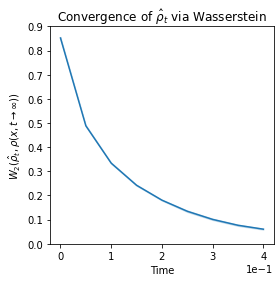

In [215]:
save_path = os.path.join(outdir, exp_name + '_convergence')
#save_path = None
#fig, ax = plt.subplots(figsize=(5,5))
#cb4.figsize = (4,4)
cb4_new.plot(stack=True, ylim=(0,0.9), save_path = save_path)
plt.show()

###### Aggregated Plot of Functional Values

../out/craig_pdes/pme_τ0.001_it1000_strNone_F_convergence


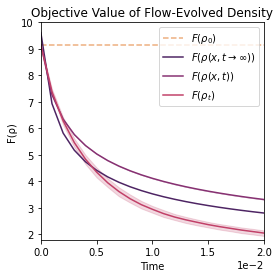

In [80]:
#cb2.plot_F_estim = False
save_path = os.path.join(outdir, exp_name + '_F_convergence')
print(save_path)
#save_path = None
cb2.save_path = save_path
cb2.plot_F_obj = False
cb2.plot_F_estim = True
cb2.figsize = (4,4)
cb2.plot(save_path=save_path, xlim = (0.0, 0.02), ylim=(1.8,10))

##### Aggregated Plot of Distances

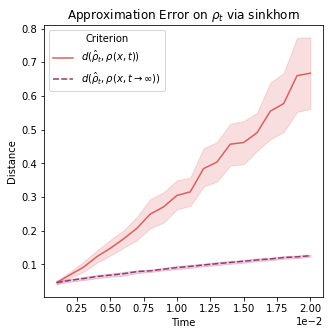

In [116]:
save_path = os.path.join(outdir, exp_name + '_distances')
#save_path = None
cb3.save_path = save_path
cb3.plot(stack=True)#, save_path = save_path)

##### Aggregated Plot of Densities

In [131]:
XT = XT.view(1000,1,21,10)

../out/craig_pdes/pme_τ0.001_it1000_strNone_density


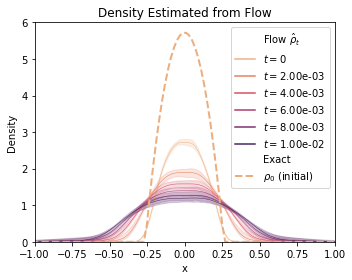

In [143]:

import src.utils
importlib.reload(src.utils)

from src.utils import averaged_density_plot

save_path = os.path.join(outdir, exp_name + '_density')
print(save_path)
save_path = None
averaged_density_plot(XT[:,:,:11,:],ρ0=ρ0, ρinf=None, step_size = gf.τ, freq=2, figsize=(5,4), domain=(-2,2),
                      xrng=(-1,1), yrng=(0,6), npoints=200, bw=0.3, 
                      title='Density Estimated from Flow',
                      save_path=save_path)

../out/craig_pdes/pme_exact_density
tensor(0.0010, dtype=torch.float64)
tensor(0.0030, dtype=torch.float64)
tensor(0.0070, dtype=torch.float64)
tensor(0.0130, dtype=torch.float64)
tensor(0.0210, dtype=torch.float64)
tensor(0.0310, dtype=torch.float64)


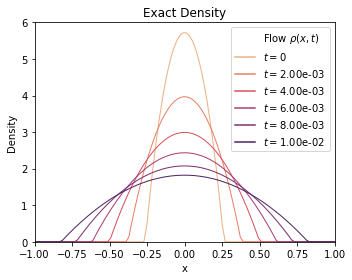

In [161]:
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import copy

import src.utils
importlib.reload(src.utils)

from src.utils import averaged_density_plot

save_path = os.path.join(outdir, 'pme_exact_density')
print(save_path)
#save_path = None
averaged_density_plot(XT[:,:,:11,:],ρ0=ρ0,ρt=copy.deepcopy(ρ0),ρinf=None, step_size = gf.τ, freq=2, figsize=(5,4), domain=(-2,2),
                      xrng=(-1,1), yrng=(0,6), npoints=200, bw=0.3, 
                      title='Exact Density', plot_flow=False,
                      save_path=save_path)

In [93]:
from IPython.display import HTML
HTML(cb1.animation.to_html5_video())

# 2. Nonlinear Fokker-Planck equation

<class 'float'>
(-1.069912193933663, 1.069912193933663)


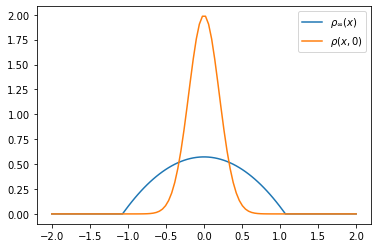

(-1.069912193933663, 1.069912193933663)

In [129]:

import src.pde
importlib.reload(src.pde)

from src.pde import FokkerPlanckNonLinDiff

C = (3/16)**(1/3)
t0 = 1e-3
m = 2

x = torch.linspace(-2, 2, 100)

V = lambda x: torch.pow(x,2)

print(type(t0))

ρinf = FokkerPlanckNonLinDiff(m=m, C=C)

μ, σ = torch.tensor(0.0), torch.tensor(0.2)
ρ0 = torch.distributions.Normal(μ, σ)
X = ρ0.sample((100,))
ρ0.domain = (-5.0,5.0)
#ρinf.domain = (-2.,2.)
print(ρinf.domain)

fig, ax = plt.subplots()

ax.plot(x, torch.exp(ρinf.log_prob(x)), label=r'$\rho_{\infty}(x)$')
ax.plot(x, torch.exp(ρ0.log_prob(x)), label=r'$\rho(x,0)$')
ax.legend()

plt.show()


ρinf.get_domain()

#### Define + Evaluate Functional at Initial and Steady State Distribs

In [131]:
import src.functionals 
importlib.reload(src.functionals)
from src.utils import meshgrid_from

from src.functionals import InternalEnergyFunctional, PotentialFunctional, FunctionalSum

f = lambda x: torch.pow(x, m)
multfun = lambda logr: torch.exp((m-1)*logr)

F1 = InternalEnergyFunctional(f, ρ0, X, multfun)
F2 = PotentialFunctional(V)
F = FunctionalSum([F1, F2])
#F = F1
#F = F2

## Evaluation by integration of initial and steady state distributions
x, npoints = meshgrid_from(ρ=ρ0,  npoints_dim = 1001)
print(f'F(ρ0) with domain ({x.min().item():6.2f},{x.max().item():6.2f}) = {F.exact_eval(x,ρ=ρ0).item():4.2f}')
print(f'F(ρinf) with domain ({x.min().item():6.2f},{x.max().item():6.2f}) = {F.exact_eval(x,ρ=ρinf).item():4.2f}')


x, npoints = meshgrid_from(ρ=ρinf,  npoints_dim = 1001)
print(f'F(ρ0) with domain ({x.min().item():6.2f},{x.max().item():6.2f}) = {F.exact_eval(x,ρ=ρ0).item():4.2f}')
print(f'F(ρinf) with domain ({x.min().item():6.2f},{x.max().item():6.2f}) = {F.exact_eval(x,ρ=ρinf).item():4.2f}')
#print(f'{X.min().item():6.2f},{X.max().item():6.2f}, {F.sample_eval(X.view(-1,1),ρ=ρ0).item():4.2f}')


> /Users/daalvare/workspace/GFICNN/src/functionals.py(289)exact_eval()
-> def get_delta(u):
(Pdb) c
F(ρ0) with domain ( -5.00,  5.00) = 1.45
> /Users/daalvare/workspace/GFICNN/src/functionals.py(289)exact_eval()
-> def get_delta(u):
(Pdb) fx.shape
torch.Size([1001, 1])
(Pdb) q


BdbQuit: 

No rdkit
tsnecuda not found - will use (slower) cpu implementation
tensor(1.4505)
tensor(0.5608)
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   9.07e-02    -0.27     -0.46  1.94e-01     0.03     0.28   2.62e-01
 100   2.27e-03    -0.23     -0.28  5.04e-02     0.03     0.03   2.29e-04
 200   2.23e-03    -0.23     -0.28  5.01e-02     0.03     0.03   1.31e-05
 300   2.23e-03    -0.22     -0.27  5.01e-02     0.03     0.03   2.43e-05
 400   2.24e-03    -0.22     -0.27  5.02e-02     0.03     0.03   4.65e-05
 500   2.26e-03    -0.22     -0.27  5.03e-02     0.03     0.03   3.99e-05
 600   2.26e-03    -0.22     -0.27  5.02e-02     0.03     0.03   4.61e-05
 700   2.26e-03    -0.22     -0.27  5.03e-02     0.03     0.03   3.53e-05
 800   2.24e-03    -0.22     -0.27  5.03e-02     0.03     0.03   9.78e

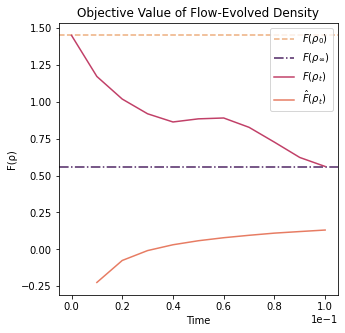

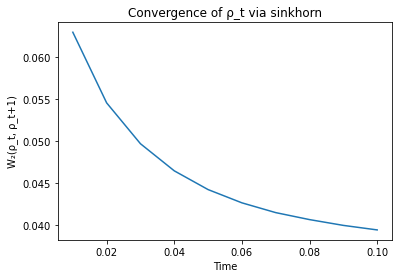

In [203]:
import importlib
import warnings
warnings.filterwarnings("ignore", message="distplot")

import src.flow
import src.utils
import src.pde
import src.callbacks
import src.functionals
import cpflow.lib.logdet_estimators
%matplotlib inline

importlib.reload(src.flow)
importlib.reload(src.utils)
importlib.reload(src.pde)
importlib.reload(src.callbacks)
importlib.reload(src.functionals)
importlib.reload(cpflow.lib.logdet_estimators)

from src.pde import FokkerPlanckNonLinDiff
from src.flow import GradFlow
from src.utils import infer_input_type, invert_potential, density_plot_1d, meshgrid_from
from src.callbacks import PlottingCallback, DensityEvaluationCallback, CallbackList, FunctionalValueCallback
from src.callbacks import ConvergenceCallback
from src.functionals import Functional, PotentialFunctional, InternalEnergyFunctional, FunctionalSum
from cpflow.lib.logdet_estimators import unbiased_logdet
from lib.icnn import ICNN, ICNN2, ICNN3, DenseICNN2, ResICNN2

from src.icnn import FICNN

f = lambda x: torch.pow(x, m)
multfun = lambda logr: torch.exp((m-1)*logr)

#ρ0.reset()


F1 = InternalEnergyFunctional(f, ρ0, X, multfun)
F2 = PotentialFunctional(V)
F = FunctionalSum([F1, F2])
#F = F1


## Evaluation by integration of initial and steady state distributions
x, npoints = meshgrid_from(ρ=ρinf,  npoints_dim = 1001)
print(F.exact_eval(x,ρ=ρ0))
print(F.exact_eval(x,ρ=ρinf))



save_path = None
#save_path = os.path.join(outdir, 'aggregation')

cb1 = PlottingCallback(animate=True, display_freq=1, same_fig=True,
                       show_density=True, ρinf = ρinf,  figsize=(5,5), 
                       density_method='kde',  use_sns=True, xrng=(-2,2), yrng=(0,2), 
                       show_trajectories=False, plot_pad=0.5, save_path=save_path)

#cb2 = FunctionalValueCallback(F, ρinf=ρinf, domain=(-2,2))

cb2 = FunctionalValueCallback(F, ρ0=ρ0, ρinf=ρinf, integral_domain=(-2.0,2.0),
                              plot_F_obj=True, plot_F_estim=True)

cb3 = ConvergenceCallback(ρ_target=ρinf)

cb = CallbackList([cb1, cb2, cb3]) 


factory = lambda: FICNN(input_dim=1, hidden_dims=[100,100], nonlin='leaky_relu', dropout=0)
factory = lambda: FICNN(input_dim=1, hidden_dims=[200,50,20], nonlin='leaky_relu', dropout=0)
#factory = lambda: FICNN(input_dim=1, hidden_dims=[50,20,10], nonlin='leaky_relu', dropout=0)


#factory = lambda: ResICNN2(dim=1, dimh=5)

gf = GradFlow(X, F=F, ρ0=ρ0, τ=1e-2, lr = 1e-3, strongify_icnn=None, convex_net = factory,# ResICNN2(dim=1, dimh=5),
              callbacks=cb, optimizer = 'adam', opt_iters=1000)

XT = gf.flow(steps=10)
plt.show()

In [202]:
from IPython.display import HTML
HTML(cb1.animation.to_html5_video())

#### Averaging Across Multiple Restarts

------------- FLOW WITH RANDOM RESTART # 1 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   3.51e-02    -0.09     -0.18  9.10e-02     0.00     0.18   1.77e-01
 100   2.06e-03    -0.20     -0.26  5.34e-02     0.00     0.00   3.46e-04
 200   2.08e-03    -0.21     -0.26  5.35e-02     0.00     0.00   4.18e-05
 300   2.09e-03    -0.21     -0.26  5.35e-02     0.00     0.00   2.38e-05
 400   2.09e-03    -0.21     -0.26  5.35e-02     0.00     0.00   2.58e-05
 500   2.09e-03    -0.21     -0.26  5.35e-02     0.00     0.00   4.42e-05
 600   2.08e-03    -0.21     -0.26  5.35e-02     0.00     0.00   7.07e-05
 700   2.08e-03    -0.21     -0.27  5.35e-02     0.00     0.00   5.34e-05
 800   2.10e-03    -0.21     -0.26  5.36e-02     0.00     0.00   1.10e

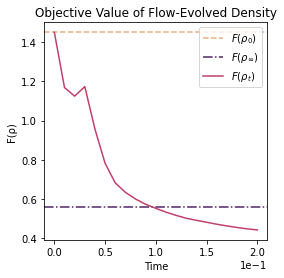

------------- FLOW WITH RANDOM RESTART # 2 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   9.48e-01     0.86     -0.26  1.12e+00     0.04     1.01   9.67e-01
 100   1.96e-03    -0.14     -0.20  6.52e-02     0.04     0.04   5.57e-04
 200   1.92e-03    -0.15     -0.22  6.50e-02     0.04     0.04   3.71e-05
 300   1.91e-03    -0.16     -0.22  6.48e-02     0.04     0.04   1.12e-05
 400   1.89e-03    -0.16     -0.23  6.47e-02     0.04     0.04   1.24e-05
 500   1.89e-03    -0.16     -0.23  6.47e-02     0.04     0.04   1.04e-05
 600   1.89e-03    -0.16     -0.23  6.47e-02     0.04     0.04   7.21e-06
 700   1.89e-03    -0.16     -0.23  6.47e-02     0.04     0.04   2.71e-05
 800   1.88e-03    -0.17     -0.23  6.46e-02     0.04     0.04   2.05e

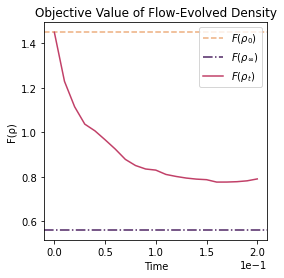

------------- FLOW WITH RANDOM RESTART # 3 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[0.0,1.0] to balance them.
   0   2.64e-01     0.06     -0.34  4.08e-01     0.00     0.46   4.69e-01
 100   1.73e-03    -0.13     -0.21  7.11e-02     0.00     0.00   9.27e-05
 200   1.67e-03    -0.14     -0.21  7.07e-02     0.00     0.00   2.11e-05
 300   1.69e-03    -0.14     -0.21  7.08e-02     0.00     0.00   1.28e-05
 400   1.69e-03    -0.14     -0.21  7.08e-02     0.00     0.00   1.14e-05
 500   1.70e-03    -0.14     -0.21  7.08e-02     0.00     0.00   3.95e-05
 600   1.70e-03    -0.14     -0.21  7.09e-02     0.00     0.00   5.31e-05
 700   1.71e-03    -0.13     -0.20  7.09e-02     0.00     0.00   1.20e-04
 800   1.70e-03    -0.13     -0.20  7.09e-02     0.00     0.00   2.31e-0

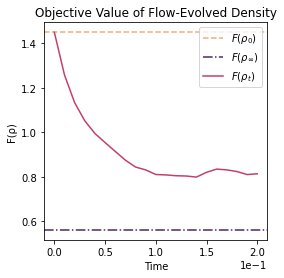

------------- FLOW WITH RANDOM RESTART # 4 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   2.75e+00     2.48     -0.54  3.02e+00     0.01     1.60   1.59e+00
 100   2.17e-02    -0.19     -0.32  1.27e-01     0.01     0.03   1.71e-03
 200   3.92e-03    -0.10     -0.17  7.39e-02     0.01     0.01   2.08e-04
 300   2.27e-03    -0.12     -0.19  6.66e-02     0.01     0.01   1.06e-04
 400   2.04e-03    -0.14     -0.20  6.57e-02     0.01     0.01   5.61e-05
 500   2.00e-03    -0.15     -0.21  6.58e-02     0.01     0.01   1.69e-05
 600   1.97e-03    -0.15     -0.21  6.57e-02     0.01     0.01   1.03e-05
 700   1.96e-03    -0.15     -0.21  6.57e-02     0.01     0.01   3.80e-05
 800   1.94e-03    -0.15     -0.21  6.56e-02     0.01     0.01   5.35e

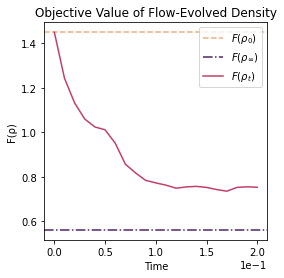

------------- FLOW WITH RANDOM RESTART # 5 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
   0   5.78e-01    62.38     61.70  6.79e-01     0.03     0.78   7.51e-01
 100   2.05e-03    -0.18     -0.24  5.88e-02     0.03     0.03   8.44e-04
 200   1.94e-03    -0.19     -0.25  5.82e-02     0.03     0.03   2.73e-05
 300   1.98e-03    -0.18     -0.24  5.85e-02     0.03     0.03   2.73e-05
 400   2.01e-03    -0.18     -0.24  5.86e-02     0.03     0.03   2.94e-05
 500   2.01e-03    -0.18     -0.24  5.85e-02     0.03     0.03   1.98e-05
 600   2.00e-03    -0.19     -0.24  5.85e-02     0.03     0.03   2.35e-05
 700   2.03e-03    -0.18     -0.24  5.88e-02     0.03     0.03   7.67e-05
 800   1.98e-03    -0.19     -0.24  5.85e-02     0.03     0.03   1.14e-04
 900   2.01e-03    -0.18     -0.24  5.86e-02     0.03     0.03   8.73e-05
1000   2.01e-03    -0.18     -0.24  5.86e-

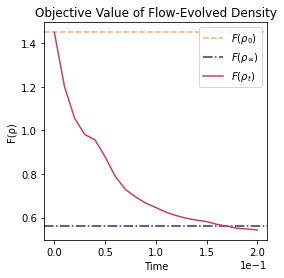

------------- FLOW WITH RANDOM RESTART # 6 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   1.19e+00     0.79     -0.52  1.30e+00     0.00     1.06   1.07e+00
 100   4.47e-03    -0.21     -0.27  5.93e-02     0.00     0.01   4.17e-04
 200   2.32e-03    -0.19     -0.24  5.10e-02     0.00     0.00   4.01e-04
 300   2.29e-03    -0.21     -0.26  5.10e-02     0.00     0.00   4.32e-05
 400   2.24e-03    -0.22     -0.27  5.08e-02     0.00     0.00   2.35e-05
 500   2.22e-03    -0.22     -0.27  5.07e-02     0.00     0.00   4.48e-05
 600   2.19e-03    -0.22     -0.27  5.05e-02     0.00     0.00   3.28e-05
 700   2.18e-03    -0.22     -0.27  5.05e-02     0.00     0.00   7.26e-06
 800   2.18e-03    -0.22     -0.27  5.05e-02     0.00     0.00   8.56e

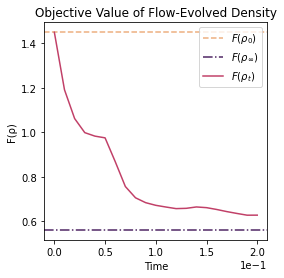

------------- FLOW WITH RANDOM RESTART # 7 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   2.84e-01     0.19     -0.17  3.55e-01     0.00     0.53   5.29e-01
 100   2.23e-03    -0.15     -0.22  6.58e-02     0.00     0.00   8.36e-04
 200   1.86e-03    -0.16     -0.23  6.36e-02     0.00     0.00   2.93e-05
 300   1.87e-03    -0.16     -0.23  6.37e-02     0.00     0.00   3.05e-05
 400   1.87e-03    -0.16     -0.23  6.37e-02     0.00     0.00   2.29e-05
 500   1.87e-03    -0.16     -0.23  6.38e-02     0.00     0.00   1.37e-05
 600   1.87e-03    -0.16     -0.23  6.38e-02     0.00     0.00   1.39e-05
 700   1.86e-03    -0.16     -0.23  6.37e-02     0.00     0.00   2.09e-05
 800   1.86e-03    -0.17     -0.23  6.37e-02     0.00     0.00   2.92e

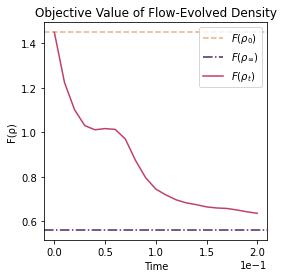

------------- FLOW WITH RANDOM RESTART # 8 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[0.0,1.0] to balance them.
   0   2.51e-01    -0.09     -0.52  4.23e-01     0.01     0.39   4.10e-01
 100   3.40e-02    85.15     85.01  1.43e-01     0.01     0.01   2.03e-02
 200   3.06e-02    -0.35     -0.49  1.38e-01     0.01     0.01   3.76e-04
 300   2.60e-02    85.70     85.58  1.27e-01     0.01     0.01   1.93e-02
 400   2.33e-02    -0.34     -0.47  1.22e-01     0.01     0.01   1.85e-03
 500   1.77e-02    -0.34     -0.45  1.09e-01     0.01     0.01   2.25e-03
 600   1.42e-02    -0.33     -0.43  1.00e-01     0.01     0.01   2.55e-02
 700   1.05e-02    -0.31     -0.40  8.96e-02     0.01     0.00   9.82e-03
 800   1.44e-02    -0.33     -0.43  1.01e-01     0.01     0.01   2.44e-0

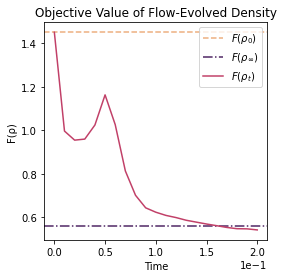

------------- FLOW WITH RANDOM RESTART # 9 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[0.0,1.0] to balance them.
   0   4.13e-01     0.17     -0.32  4.89e-01     0.01     0.62   6.30e-01
 100   2.22e-03    -0.17     -0.23  6.00e-02     0.01     0.01   1.91e-04
 200   1.97e-03    -0.18     -0.24  5.88e-02     0.01     0.01   9.54e-06
 300   1.95e-03    -0.19     -0.24  5.87e-02     0.01     0.01   7.96e-06
 400   2.01e-03    -0.18     -0.24  5.90e-02     0.01     0.01   1.36e-04
 500   2.02e-03    -0.18     -0.24  5.91e-02     0.01     0.01   4.45e-05
 600   1.97e-03    -0.18     -0.24  5.88e-02     0.01     0.01   5.64e-05
 700   1.99e-03    -0.18     -0.24  5.89e-02     0.01     0.01   9.72e-05
 800   1.99e-03    -0.18     -0.24  5.89e-02     0.01     0.01   6.96e-0

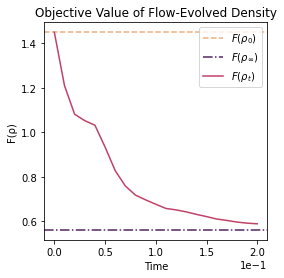

------------- FLOW WITH RANDOM RESTART # 10 -------------
Density BW: None
Exact query ranges: tensor(-5.0000) tensor(5.0000)


------------------------------------------------------------------------
Iter   W(ρ,ρ_t)  F(ρ)=       ℱ(ρ)   +  𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------------------------
Relative ratio between F and W terms in JKO is too unbalanced...
consider choosing τ in 10^[-1.0,-0.0] to balance them.
   0   8.49e-01     0.66     -0.50  1.16e+00     0.01     0.62   7.50e-01
 100   2.26e-03    -0.15     -0.20  5.53e-02     0.01     0.01   3.32e-04
 200   2.38e-03    -0.18     -0.24  5.61e-02     0.01     0.01   3.80e-04
 300   2.10e-03    -0.20     -0.25  5.47e-02     0.01     0.01   1.07e-05
 400   2.09e-03    -0.20     -0.26  5.47e-02     0.01     0.01   7.92e-05
 500   2.08e-03    -0.20     -0.26  5.46e-02     0.01     0.01   4.74e-06
 600   2.08e-03    -0.20     -0.26  5.47e-02     0.01     0.01   2.18e-05
 700   2.08e-03    -0.20     -0.26  5.47e-02     0.01     0.01   9.08e-06
 800   2.08e-03    -0.20     -0.26  5.47e-02     0.01     0.01   9.78e

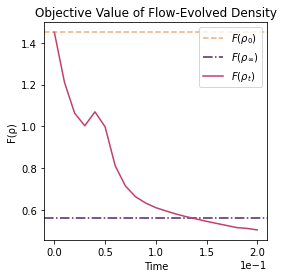

Done with loops
> /Users/daalvare/workspace/GFICNN/src/flow.py(553)flow_repeatedly()
-> X_joint_hist  = torch.cat(X_joint_hist, dim = -1)  # n x d x t x reps
(Pdb) c


In [217]:
cb = CallbackList([cb1, cb2]) 
gf = GradFlow(X, F=F, ρ0=ρ0, τ=1e-2, lr = 1e-3, strongify_icnn=None, convex_net = factory,
              callbacks=cb, optimizer = 'adam', opt_iters=1000)

XT = gf.flow_repeatedly(samples=100, steps=20, repetitions=10)

In [218]:
_F_estim_hist = cb2.F_estim_hist.copy()

In [219]:
import numpy as np
print(cb2.F_estim_hist.max())
print(cb2.F_estim_hist)
print(len(cb2.times))

# #idx_delete = np.where

# idx_keep = np.where(cb2.F_estim_hist.max(axis=1) < 1.5)
# print(idx_keep)
# #_F_estim_hist = cb2.F_estim_hist.copy()

# # # idx_delete = 2
# cb2.F_estim_hist = cb2.F_estim_hist[idx_keep]
# cb2.times = cb2.times[idx_keep]

# print(cb2.F_estim_hist.max())

# print(len(cb2.F_estim_hist), len(cb2.times))

1.4504436
[[1.4504436  1.1681463  1.1242656  1.1731286  0.95660216 0.7818202
  0.6817401  0.6335123  0.5991977  0.57234126 0.55179304 0.53219146
  0.5157057  0.5009821  0.49055967 0.48069435 0.4705695  0.4618962
  0.45395082 0.4469257  0.44148412]
 [1.4504436  1.229467   1.1150132  1.0369282  1.0066751  0.96659034
  0.92485636 0.87823975 0.8506072  0.8349429  0.829967   0.8104929
  0.8014301  0.7942101  0.7894356  0.7869032  0.7760826  0.77622795
  0.77784467 0.7817249  0.79026705]
 [1.4504436  1.2582911  1.1335018  1.0518978  0.9948892  0.95391566
  0.9143351  0.87467766 0.84388894 0.83089316 0.81019825 0.8083278
  0.80462337 0.80341184 0.7985276  0.8200051  0.8345954  0.8309729
  0.82349634 0.8099058  0.8134626 ]
 [1.4504436  1.2433668  1.1320555  1.059572   1.0241715  1.0114769
  0.95118266 0.8567075  0.81737506 0.78374004 0.7724166  0.7622588
  0.74860466 0.75428265 0.7567229  0.7521343  0.74238896 0.7351272
  0.7521037  0.75473976 0.75279826]
 [1.4504436  1.2009641  1.0554022  0.9

In [207]:
exp_name = f'fplanck_τ{gf.τ}_it{gf.opt_iters}_str{gf.strongify_icnn}'

../out/craig_pdes/fplanck_τ0.01_it1000_strNone_F_convergence


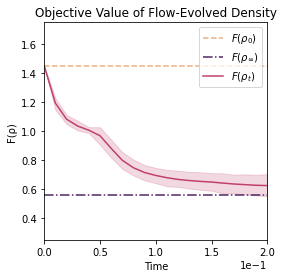

In [222]:
#cb2.plot_F_estim = False

save_path = os.path.join(outdir, exp_name + '_F_convergence')
print(save_path)
#save_path = None
cb2.save_path = save_path
cb2.plot_F_obj = False
cb2.figsize = (4,4)
cb2.plot(save_path=save_path, xlim = (0.0, 0.2), ylim=(0.25, 1.75))

In [49]:
print(XT.shape) # samples, dim, steps, reps
print(XT[:,:,0,:].min(dim=0)[0])
print(XT[:,:,0,:].max(dim=0)[0])
print(XT[:,:,-1,:].min(dim=0)[0])
print(XT[:,:,-1,:].max(dim=0)[0])

torch.Size([1000, 1, 11, 12])
tensor([[-0.5774, -0.6365, -0.7820, -0.6489, -0.5689, -0.5758, -0.5956, -0.8144,
         -0.7340, -0.6262, -0.6603, -0.6993]])
tensor([[0.5059, 0.5642, 0.5799, 0.5712, 0.6409, 0.5901, 0.6468, 0.6321, 0.7050,
         0.5245, 0.7248, 0.5876]])
tensor([[-0.8024, -0.7572, -0.7998, -0.6459, -0.5384, -0.6142, -0.5365, -0.6676,
         -0.6487, -0.5615, -0.5423, -0.5687]])
tensor([[0.9248, 0.6305, 0.5732, 0.9047, 0.5935, 0.5806, 0.5426, 0.5230, 0.5540,
         0.5637, 0.5939, 0.4307]])


../out/craig_pdes/fplanck_τ0.01_it1000_strNone_ρ_convergence


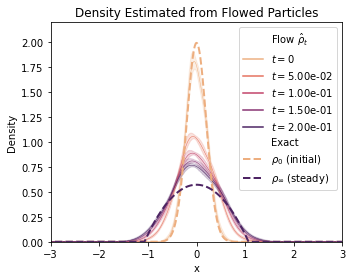

In [231]:
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

import src.utils
importlib.reload(src.utils)

from src.utils import averaged_density_plot

save_path = os.path.join(outdir, exp_name + '_ρ_convergence')

print(save_path)
#save_path = None
averaged_density_plot(XT[:,:,:,:],ρ0=ρ0, ρinf=ρinf, step_size = gf.τ, freq = 5, figsize=(5,4), domain=(-4,4),
                      xrng=(-3,3), yrng=(0,2.2), npoints=1000, bw=0.4, 
                      title='Density Estimated from Flowed Particles',
                      save_path=save_path)

In [ ]:
## TODO: add initial eval if possible to these functionals to avoid None in first F_obj_hist

# 3. Aggregation Equation

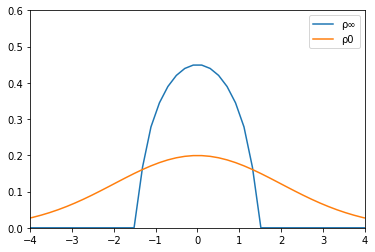

In [155]:
import src.pde
importlib.reload(src.pde)
from src.pde import AggregationEquilibrium

ρinf = AggregationEquilibrium()

μ, σ = torch.tensor(0.0), torch.tensor(2.0)
ρ0 = torch.distributions.Normal(μ, σ)
X = ρ0.sample((1000,))
ρ0.domain = (-10.0,10.0)
ρinf.domain = (-4.0,4.0)


x = torch.linspace(*ρ0.domain,100)

fig, ax = plt.subplots()
ax.set_xlim(-4,4)
ax.set_ylim(0,0.6)
ax.plot(x, torch.exp(ρinf.log_prob(x)), label='ρ∞')
ax.plot(x, torch.exp(ρ0.log_prob(x)), label='ρ0')
ax.legend()
plt.show()

#### Evaluate Functional value of Initial and Steady State Distribs

In [293]:
import src.functionals 
importlib.reload(src.functionals)
from src.functionals import InteractionFunctional


#W = lambda x: 0.5*torch.pow(torch.norm(x, dim=-1),2) - torch.log(torch.norm(x,dim=-1))
W = lambda x: 0.5*torch.pow(x,2).sum(dim=-1) - torch.log(torch.norm(x,dim=-1))
F = InteractionFunctional(W)

## Evaluation by integration of initial and steady state distributions
x, npoints = meshgrid_from(ρ=ρ0,  npoints_dim = 1001)
print(f'{x.min().item():6.2f},{x.max().item():6.2f}, {F.exact_eval(x,ρ=ρ0).item():4.2f}')
print(f'{x.min().item():6.2f},{x.max().item():6.2f}, {F.exact_eval(x,ρ=ρinf).item():4.2f}')


x, npoints = meshgrid_from(ρ=ρinf,  npoints_dim = 1001)
print(f'{x.min().item():6.2f},{x.max().item():6.2f}, {F.exact_eval(x,ρ=ρinf).item():4.2f}')
print(f'{X.min().item():6.2f},{X.max().item():6.2f}, {F.sample_eval(X.view(-1,1),ρ=ρ0).item():4.2f}')


-10.00, 10.00, 1.79
-10.00, 10.00, 0.53
 -4.00,  4.00, 0.54
 -5.81,  6.84, 1.69


In [335]:
import importlib
import src.flow
import src.utils
import src.pde
import src.callbacks
import src.functionals
import cpflow.lib.logdet_estimators
%matplotlib inline

importlib.reload(src.flow)
importlib.reload(src.utils)
importlib.reload(src.pde)
importlib.reload(src.callbacks)
importlib.reload(src.functionals)
importlib.reload(cpflow.lib.logdet_estimators)

from src.flow import GradFlow
from src.functionals import InteractionFunctional
from src.callbacks import FunctionalValueCallback, ConvergenceCallback, CallbackList
from src.callbacks import PlottingCallback
from src.utils import meshgrid_from
from src.icnn import FICNN

save_path = None
#save_path = os.path.join(outdir, 'aggregation')

cb1 = PlottingCallback(animate=False, display_freq=5, same_fig=True,
                       show_density=True, ρ0=ρ0, ρinf = ρinf,  figsize=(4,4), 
                       density_method='kde',  use_sns=True, xrng=(-4,4), yrng=(0,0.6), 
                       show_trajectories=False, plot_pad=0.5, save_path=save_path)

cb2 = FunctionalValueCallback(F, ρ0=ρ0, ρinf=ρinf, integral_domain=(-10.0,10.0),
                              plot_F_obj=True, plot_F_estim=False)

cb3 = ConvergenceCallback(ρ_target=ρinf)

cb = CallbackList([cb1, cb2, cb3]) 

factory = lambda: FICNN(input_dim=1, hidden_dims=[50,50,50], nonlin='leaky_relu', dropout=0)


# Fast setting:  τ=1e0, opt_iters=200
# Slow setting:  τ=1e-1, opt_iters=2000
gf = GradFlow(X, F=F, ρ0=ρ0, τ=1e0, lr = 1e-3, strongify_icnn=1e-12, convex_net = factory,# ResICNN2(dim=1, dimh=5),
              callbacks=cb, optimizer = 'adam', opt_iters=100)

#XT = gf.flow(steps=2)
#plt.show()


No rdkit
tsnecuda not found - will use (slower) cpu implementation


#### Averaging Across Multiple Restarts

------------- FLOW WITH RANDOM RESTART # 0 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       2.11   5.21e+00     0.02     0.25   1.09e+00
 100       0.67   9.03e-01     0.02     0.04   1.18e-03
 200       0.66   8.91e-01     0.02     0.00   2.96e-04
 300       0.66   8.79e-01     0.02     0.01   1.44e-04
 400       0.66   8.74e-01     0.02     0.02   9.40e-05
 500       0.65   8.69e-01     0.02     0.02   3.28e-04
 600       0.65   8.71e-01     0.02     0.02   1.26e-04
 700       0.65   8.69e-01     0.02     0.02   2.56e-04
 800       0.65   8.67e-01     0.02     0.01   9.97e-05
 900       0.65   8.64e-01     0.02     0.01   4.25e-05
1000       0.65   8.64e-01     0.02     0.01   1.65e-04

---> After JKO Step: 1, F(ρ)=8.6530e-01 <---

inversion error 0.37545135617256165
F(ρₜ)=1959.6931 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖

../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.12   7.05e-01     0.01     0.04   2.77e-03
 200       0.11   6.63e-01     0.01     0.01   1.49e-03
 300       0.11   6.70e-01     0.01     0.01   1.06e-03
 400       0.11   6.65e-01     0.01     0.02   3.05e-03
 500       0.11   6.37e-01     0.01     0.01   2.68e-03
 600       0.11   6.63e-01     0.01     0.01   5.30e-04
 700       0.12   6.94e-01     0.01     0.03   2.81e-02
 800       0.12   6.54e-01     0.01     0.01   3.06e-03
 900       0.11   6.53e-01     0.01     0.02   1.59e-03
1000       0.11   6.50e-01     0.01     0.01   6.15e-04

---> After JKO Step: 2, F(ρ)=6.4947e-01 <---

inversion error 0.13615894317626953
inversion error 0.32717230916023254
F(ρₜ)=475.4787 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.31   7.33e-01     0.01     0.51   5.20e-01
 100       0.01   6.24e-01     0.01     0.01   4.73e-03
 200  

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.18496829271316528
inversion error 0.050566673278808594
inversion error 0.11372947692871094
inversion error 0.2831364870071411
F(ρₜ)=  4.0436 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.84   8.14e-01     0.02     0.72   7.42e-01


../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.00   5.62e-01     0.02     0.01   1.64e-03
 200       0.00   5.56e-01     0.02     0.02   4.36e-04
 300       0.00   5.54e-01     0.02     0.02   7.36e-04
 400       0.00   5.56e-01     0.02     0.02   4.10e-03
 500       0.00   5.54e-01     0.02     0.02   1.40e-03
 600       0.00   5.54e-01     0.02     0.02   1.17e-03
 700       0.00   5.55e-01     0.02     0.02   7.97e-04
 800       0.00   5.54e-01     0.02     0.02   2.55e-03
 900       0.02   5.70e-01     0.02     0.06   1.01e-02
1000       0.00   5.56e-01     0.02     0.02   8.72e-03

---> After JKO Step: 6, F(ρ)=5.5702e-01 <---

inversion error 0.030438989400863647
inversion error 0.04894721508026123
inversion error 0.19798485934734344
inversion error 0.0452876091003418
inversion error 0.12446784973144531
inversion error 0.30998659133911133
F(ρₜ)=  1.6176 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
-----------------------------

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.04400146007537842
inversion error 0.031041622161865234
inversion error 0.07593512535095215
inversion error 0.027062833309173584
inversion error 0.04237532615661621
inversion error 0.026997804641723633
inversion error 0.0472254753112793
inversion error 0.08797454833984375
inversion error 0.3016689717769623
F(ρₜ)=  0.8034 (via exact computation)


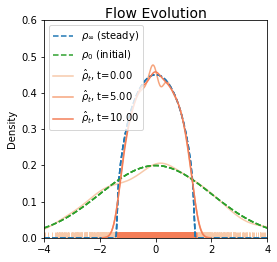

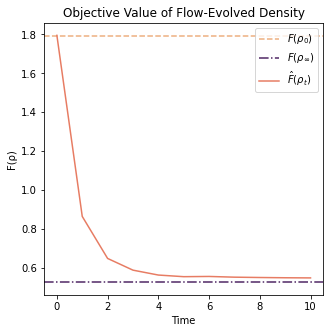

------------- FLOW WITH RANDOM RESTART # 1 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       3.26   5.84e+00     0.02     0.79   1.20e+00


../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.65        inf     0.02     0.04   1.09e-03
 200       0.66   7.83e-01     0.02     0.02   3.24e-04
 300       0.65   7.82e-01     0.02     0.03   2.77e-04
 400       0.65   7.79e-01     0.02     0.03   4.62e-04
 500       0.65   7.79e-01     0.02     0.02   1.84e-04
 600       0.66        inf     0.02     0.02   2.10e-04
 700       0.66   7.77e-01     0.02     0.02   3.59e-04
 800       0.66        inf     0.02     0.02   1.44e-04
 900       0.66        inf     0.02     0.02   1.39e-04
1000       0.66   7.76e-01     0.02     0.02   2.23e-04

---> After JKO Step: 1, F(ρ)=     inf <---

inversion error 0.03385019302368164
F(ρₜ)=  0.8998 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       1.07   2.25e+00     0.02     0.10   8.45e-01
 100       0.11        inf     0.02     0.03   1.13e-03
 200       0.11   5.90e-01     0.02     0.02

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.06708693504333496
inversion error 0.05326223373413086
inversion error 0.02931976318359375
inversion error 0.05643466114997864
F(ρₜ)=  0.5701 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.87   7.54e-01     0.02     0.79   8.10e-01


../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.00   5.52e-01     0.02     0.02   1.30e-03
 200       0.00        inf     0.02     0.03   1.67e-04
 300       0.00   5.48e-01     0.02     0.02   2.00e-04
 400       0.00   5.48e-01     0.02     0.02   4.45e-04
 500       0.00   5.47e-01     0.02     0.02   4.05e-04
 600       0.00        inf     0.02     0.02   1.29e-04
 700       0.00   5.48e-01     0.02     0.02   2.60e-04
 800       0.00   5.47e-01     0.02     0.02   1.29e-04
 900       0.00   5.48e-01     0.02     0.02   1.43e-04
1000       0.00        inf     0.02     0.02   4.16e-04

---> After JKO Step: 6, F(ρ)=     inf <---

inversion error 0.037209510803222656
inversion error 0.046762824058532715
inversion error 0.06665515899658203
inversion error 0.03738534450531006
inversion error 0.02203845977783203
inversion error 0.03907418251037598
F(ρₜ)=  0.5284 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
-----------------------------

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.0634315013885498
inversion error 0.04560732841491699
inversion error 0.026169300079345703
inversion error 0.03537273406982422
inversion error 0.030969858169555664
inversion error 0.08632135391235352
inversion error 0.04086196422576904
inversion error 0.047428011894226074
inversion error 0.04066824913024902
F(ρₜ)=  0.3792 (via exact computation)


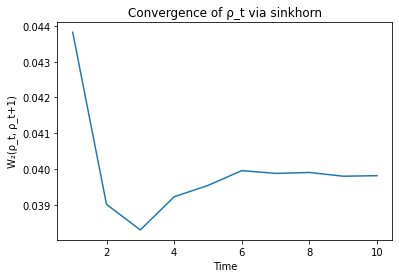

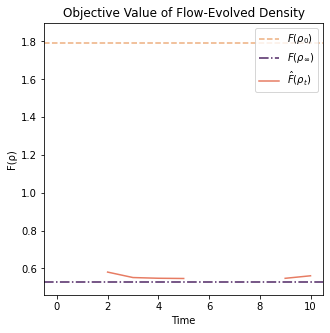

------------- FLOW WITH RANDOM RESTART # 2 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0      12.46   1.38e+01     0.10     0.68   2.89e+00


../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.66   7.97e-01     0.10     0.33   3.45e-03
 200       0.56   7.69e-01     0.10     0.18   2.28e-03
 300       0.56   7.58e-01     0.10     0.12   7.49e-04
 400       0.57   7.47e-01     0.10     0.10   6.33e-04
 500       0.56   7.48e-01     0.10     0.10   2.93e-04
 600       0.56   7.47e-01     0.10     0.10   2.73e-04
 700       0.56   7.44e-01     0.10     0.10   2.86e-04
 800       0.56   7.44e-01     0.10     0.10   2.98e-04
 900       0.54   7.55e-01     0.10     0.13   9.03e-03
1000       0.56   7.42e-01     0.10     0.10   2.16e-04

---> After JKO Step: 1, F(ρ)=7.4227e-01 <---

inversion error 0.056604743003845215
F(ρₜ)=  1.4504 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       3.83   4.46e+00     0.10     0.10   1.57e+00
 100       0.10   5.91e-01     0.10     0.13   2.10e-03
 200       0.09   5.88e-01     0.10     0

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.012020230293273926
inversion error 0.044122934341430664
inversion error 0.05420887470245361
inversion error 0.07566273212432861
F(ρₜ)=  0.9302 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.70   8.33e-01     0.10     0.53   6.35e-01
 100       0.00   5.59e-01     0.10     0.10   1.56e-03
 200       0.00   5.53e-01     0.10     0.10   9.22e-04
 300       0.00   5.52e-01     0.10     0.10   5.84e-04
 400       0.00   5.51e-01     0.10     0.10   3.12e-04
 500       0.00   5.49e-01     0.10     0.10   4.17e-04
 600       0.00   5.50e-01     0.10     0.10   4.80e-04
 700       0.00   5.51e-01     0.10     0.10   9.76e-04
 800       0.00   5.52e-01     0.10     0.10   9.34e-03
 900       0.01   5.62e-01     0.10     0.10   9.07e-03
1000       0.00   5.53e-01     0.10     0.10   1.92e-03

---> After JKO Step: 6, F(ρ)=5.521

../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 300       0.00   5.56e-01     0.19     0.20   1.37e-03
 400       0.00   5.55e-01     0.19     0.19   7.65e-04
 500       0.00   5.53e-01     0.19     0.19   4.62e-04
 600       0.00   5.54e-01     0.19     0.19   9.76e-04
 700       0.00   5.55e-01     0.19     0.19   7.59e-04
 800       0.00   5.53e-01     0.19     0.19   8.07e-04
 900       0.00   5.54e-01     0.19     0.19   1.13e-03
1000       0.00   5.54e-01     0.19     0.20   4.31e-03

---> After JKO Step: 9, F(ρ)=5.5427e-01 <---

inversion error 0.03963279724121094
inversion error 0.06758043169975281
inversion error 0.03429412841796875
inversion error 0.09042239189147949
inversion error 0.09740054607391357
inversion error 0.03520703315734863
inversion error 0.03526103496551514
inversion error 0.05418825149536133
inversion error 0.10288619995117188
F(ρₜ)=  0.6989 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
---------------------------------

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.04388618469238281
inversion error 0.05584433674812317
inversion error 0.036629676818847656
inversion error 0.10088372230529785
inversion error 0.07816600799560547
inversion error 0.013776183128356934
inversion error 0.027003049850463867
inversion error 0.05186271667480469
inversion error 0.06494021415710449
F(ρₜ)=  0.6403 (via exact computation)


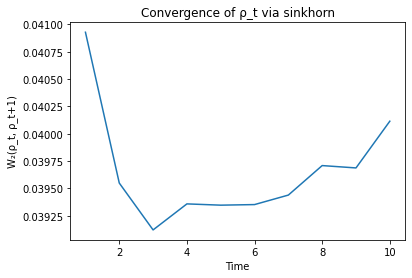

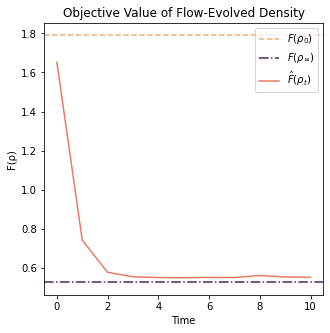

------------- FLOW WITH RANDOM RESTART # 3 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       2.16   4.99e+00     0.01     0.27   1.20e+00
 100       0.57   7.59e-01     0.01     0.08   2.34e-03
 200       0.56   7.51e-01     0.01     0.00   3.61e-04
 300       0.56   7.48e-01     0.01     0.01   2.29e-04
 400       0.56   7.46e-01     0.01     0.01   2.08e-04
 500       0.56   7.44e-01     0.01     0.01   3.03e-04
 600       0.56   7.43e-01     0.01     0.01   1.30e-04
 700       0.56   7.42e-01     0.01     0.01   3.87e-04
 800       0.56   7.41e-01     0.01     0.01   7.25e-05
 900       0.56   7.41e-01     0.01     0.01   3.51e-04
1000       0.56   7.41e-01     0.01     0.01   6.19e-04

---> After JKO Step: 1, F(ρ)=7.4217e-01 <---

inversion error 0.03876212239265442
F(ρₜ)=  1.1944 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖ 

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.07905840873718262
inversion error 0.0573725700378418
inversion error 0.03706979751586914
inversion error 0.0815591812133789
F(ρₜ)=  0.6229 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.71   6.80e-01     0.01     0.75   7.62e-01
 100       0.00   5.53e-01     0.01     0.01   7.73e-04
 200       0.00   5.49e-01     0.01     0.01   5.34e-04
 300       0.00   5.49e-01     0.01     0.01   2.39e-04
 400       0.00   5.48e-01     0.01     0.01   1.32e-04
 500       0.00   5.48e-01     0.01     0.01   3.31e-04
 600       0.00   5.48e-01     0.01     0.01   7.22e-04
 700       0.00   5.48e-01     0.01     0.01   3.79e-04
 800       0.00   5.49e-01     0.01     0.01   2.91e-04
 900       0.00   5.49e-01     0.01     0.01   2.28e-04
1000       0.00   5.49e-01     0.01     0.01   6.64e-04

---> After JKO Step: 6, F(ρ)=5.4931e-0

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.05395030975341797
inversion error 0.06362998485565186
inversion error 0.05684614181518555
inversion error 0.03101038932800293
inversion error 0.03896975517272949
inversion error 0.07820892333984375
inversion error 0.048761844635009766
inversion error 0.03585529327392578
inversion error 0.05727498233318329
F(ρₜ)=  0.4322 (via exact computation)


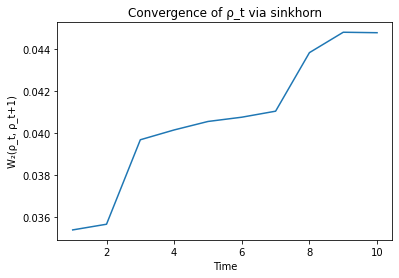

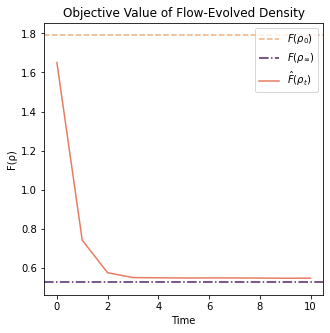

------------- FLOW WITH RANDOM RESTART # 4 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       4.42   7.51e+00     0.06     0.15   1.71e+00
 100       0.57   7.61e-01     0.06     0.02   1.14e-03
 200       0.58   7.53e-01     0.06     0.06   8.52e-04
 300       0.58   7.50e-01     0.06     0.06   1.19e-04
 400       0.59   7.47e-01     0.06     0.07   1.93e-03
 500       0.58   7.50e-01     0.06     0.06   3.80e-04
 600       0.58   7.50e-01     0.06     0.06   2.08e-04
 700       0.58   7.48e-01     0.06     0.06   2.43e-04
 800       0.58   7.48e-01     0.06     0.06   3.30e-04
 900       0.58   7.48e-01     0.06     0.06   6.06e-04
1000       0.58   7.47e-01     0.06     0.06   1.88e-04

---> After JKO Step: 1, F(ρ)=7.4721e-01 <---

inversion error 0.06494253873825073
F(ρₜ)=  1.2305 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖ 

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.030431509017944336
inversion error 0.020485401153564453
inversion error 0.056827545166015625
inversion error 0.06134319305419922
F(ρₜ)=  0.6561 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.62   8.08e-01     0.06     0.63   5.72e-01
 100       0.00   5.53e-01     0.06     0.06   1.27e-03
 200       0.00   5.50e-01     0.06     0.06   5.32e-04
 300       0.00   5.50e-01     0.06     0.06   8.39e-04
 400       0.00   5.49e-01     0.06     0.06   7.99e-05
 500       0.00   5.48e-01     0.06     0.06   1.92e-04
 600       0.00   5.47e-01     0.06     0.06   2.23e-04
 700       0.00   5.48e-01     0.06     0.06   2.18e-04
 800       0.00   5.48e-01     0.06     0.06   4.61e-04
 900       0.00   5.48e-01     0.06     0.06   1.09e-04
1000       0.00   5.48e-01     0.06     0.06   2.26e-04

---> After JKO Step: 6, F(ρ)=5.48

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.047333717346191406
inversion error 0.060128211975097656
inversion error 0.07829952239990234
inversion error 0.05370509624481201
inversion error 0.05693316459655762
inversion error 0.05153512954711914
inversion error 0.012107253074645996
inversion error 0.05232644081115723
inversion error 0.05948066711425781
F(ρₜ)=  0.8406 (via exact computation)


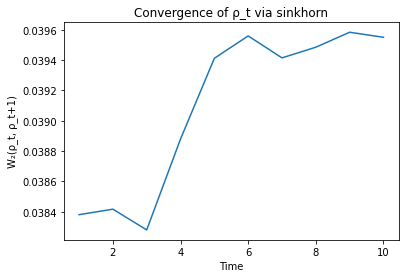

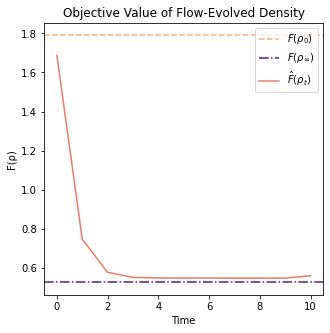

------------- FLOW WITH RANDOM RESTART # 5 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       2.53   5.70e+00     0.05     0.21   1.29e+00
 100       0.77   1.04e+00     0.05     0.20   4.79e-03
 200       0.72   1.02e+00     0.05     0.11   6.33e-04
 300       0.71   9.91e-01     0.05     0.10   2.49e-04
 400       0.70   9.71e-01     0.05     0.10   2.11e-04
 500       0.69   9.71e-01     0.05     0.10   3.16e-04
 600       0.69   9.55e-01     0.05     0.11   2.01e-04
 700       0.69   9.28e-01     0.05     0.10   1.01e-03
 800       0.68   9.04e-01     0.05     0.09   3.17e-03
 900       0.64   8.66e-01     0.05     0.06   2.09e-03
1000       0.65   8.62e-01     0.05     0.06   1.80e-04

---> After JKO Step: 1, F(ρ)=8.6218e-01 <---

inversion error 0.3952595293521881
F(ρₜ)=1716.1354 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖ 

../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.10        inf     0.06     0.06   1.30e-03
 200       0.10        inf     0.06     0.05   6.16e-03
 300       0.11        inf     0.06     0.06   2.96e-03
 400       0.11        inf     0.06     0.05   2.30e-03
 500       0.10        inf     0.06     0.02   1.15e-02
 600       0.11   6.32e-01     0.06     0.07   7.08e-03
 700       0.11        inf     0.06     0.09   8.04e-03
 800       0.09        inf     0.06     0.06   1.27e-02
 900       0.11   6.37e-01     0.06     0.08   1.97e-02
1000       0.12   6.28e-01     0.06     0.06   5.18e-03

---> After JKO Step: 2, F(ρ)=6.2967e-01 <---

inversion error 0.036440134048461914
inversion error 0.46996617317199707
F(ρₜ)= 85.9603 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.34        inf     0.06     0.28   4.96e-01
 100       0.01        inf     0.06     0.06   1.40e-03
 200 

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.07387733459472656
inversion error 0.056131839752197266
inversion error 0.14913082122802734
inversion error 0.3983517289161682
F(ρₜ)=  0.8996 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.95        inf     0.09     0.44   7.10e-01


../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.02   5.66e-01     0.09     0.10   1.10e-03
 200       0.02        inf     0.09     0.09   1.00e-03
 300       0.01        inf     0.09     0.09   5.53e-04
 400       0.01   5.55e-01     0.09     0.09   2.50e-03
 500       0.02        inf     0.09     0.07   9.14e-03
 600       0.01        inf     0.09     0.09   2.01e-03
 700       0.02        inf     0.09     0.08   1.45e-02
 800       0.08   5.66e-01     0.09     0.06   5.06e-02
 900       0.02        inf     0.09     0.13   1.06e-02
1000       0.01   5.59e-01     0.09     0.09   7.20e-04

---> After JKO Step: 6, F(ρ)=     inf <---

inversion error 0.08614689111709595
inversion error 0.07382011413574219
inversion error 0.08122503757476807
inversion error 0.05883073806762695
inversion error 0.051576003432273865
inversion error 0.441885769367218
F(ρₜ)=  0.8089 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
--------------------------------

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.020015686750411987
inversion error 0.05368638038635254
inversion error 0.020973563194274902
inversion error 0.0609300434589386
inversion error 0.0532684326171875
inversion error 0.06333255767822266
inversion error 0.0688014030456543
inversion error 0.05735102295875549
inversion error 0.3980298936367035
F(ρₜ)=  0.4611 (via exact computation)


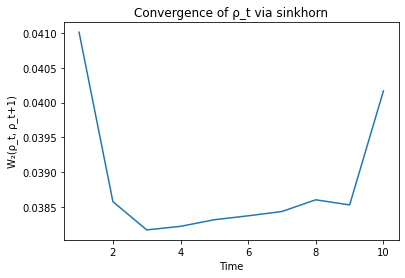

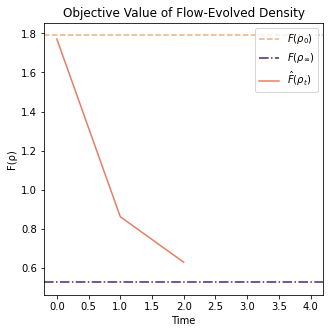

------------- FLOW WITH RANDOM RESTART # 6 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0      10.30   1.19e+01     0.02     0.95   2.61e+00
 100       0.61   7.61e-01     0.02     0.06   1.64e-03
 200       0.59   7.57e-01     0.02     0.03   4.91e-04
 300       0.59   7.54e-01     0.02     0.02   2.33e-04
 400       0.58   7.54e-01     0.02     0.02   1.85e-04
 500       0.58   7.54e-01     0.02     0.02   1.85e-04
 600       0.58   7.52e-01     0.02     0.02   2.62e-04
 700       0.59   7.48e-01     0.02     0.02   1.14e-04
 800       0.58   7.53e-01     0.02     0.02   6.63e-04
 900       0.59   7.49e-01     0.02     0.02   7.26e-05
1000       0.59   7.49e-01     0.02     0.02   1.19e-04

---> After JKO Step: 1, F(ρ)=7.4876e-01 <---

inversion error 0.15733885765075684
F(ρₜ)=  1.1958 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖ 

../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.00   5.58e-01     0.02     0.01   1.16e-03
 200       0.00   5.54e-01     0.02     0.02   7.14e-04
 300       0.00   5.52e-01     0.02     0.02   1.11e-03
 400       0.00   5.50e-01     0.02     0.02   3.42e-04
 500       0.00   5.50e-01     0.02     0.02   2.26e-04
 600       0.00   5.50e-01     0.02     0.02   1.90e-04
 700       0.00   5.50e-01     0.02     0.02   6.37e-04
 800       0.00   5.48e-01     0.02     0.02   3.22e-04
 900       0.00   5.49e-01     0.02     0.02   1.78e-04
1000       0.00   5.48e-01     0.02     0.02   1.33e-03

---> After JKO Step: 5, F(ρ)=5.4952e-01 <---

inversion error 0.02778804302215576


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.05418574810028076
inversion error 0.05987429618835449
inversion error 0.08397865295410156
inversion error 0.10482120513916016
F(ρₜ)=  0.5178 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       1.06   1.26e+00     0.02     0.36   9.05e-01
 100       0.00   5.53e-01     0.02     0.03   1.04e-03
 200       0.00   5.51e-01     0.02     0.02   3.38e-04
 300       0.00   5.49e-01     0.02     0.02   3.95e-04
 400       0.00   5.49e-01     0.02     0.02   1.93e-04
 500       0.00   5.49e-01     0.02     0.02   2.60e-04
 600       0.00   5.50e-01     0.02     0.02   3.36e-04
 700       0.00   5.49e-01     0.02     0.02   1.76e-04
 800       0.00   5.49e-01     0.02     0.02   7.83e-05
 900       0.00   5.50e-01     0.02     0.02   3.09e-04
1000       0.00   5.49e-01     0.02     0.02   3.68e-04

---> After JKO Step: 6, F(ρ)=5.4925e

../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.00   5.61e-01     0.02     0.03   1.47e-03
 200       0.00   5.53e-01     0.02     0.02   1.40e-03
 300       0.00   5.49e-01     0.02     0.02   3.42e-04
 400       0.00   5.50e-01     0.02     0.02   3.39e-04
 500       0.00   5.50e-01     0.02     0.02   3.34e-04
 600       0.00   5.49e-01     0.02     0.02   2.08e-04
 700       0.00   5.49e-01     0.02     0.02   2.53e-04
 800       0.00   5.49e-01     0.02     0.02   1.61e-04
 900       0.00   5.49e-01     0.02     0.02   2.03e-04
1000       0.00   5.50e-01     0.02     0.02   4.78e-04

---> After JKO Step: 7, F(ρ)=5.4920e-01 <---

inversion error 0.08727061748504639
inversion error 0.04490375518798828
inversion error 0.03121650218963623
inversion error 0.057213664054870605
inversion error 0.03894376754760742
inversion error 0.09039783477783203
inversion error 0.14802813529968262
F(ρₜ)=  0.5264 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.04284965991973877
inversion error 0.04333961009979248
inversion error 0.06038331985473633
inversion error 0.06985878944396973
inversion error 0.02066493034362793
inversion error 0.048572421073913574
inversion error 0.03533220291137695
inversion error 0.07911872863769531
inversion error 0.13787078857421875
F(ρₜ)=  0.5305 (via exact computation)


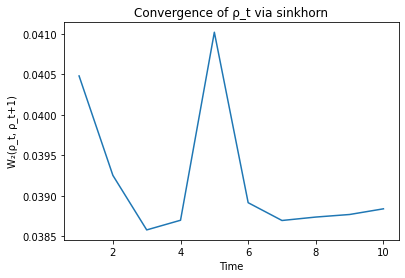

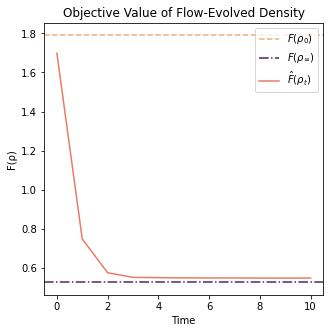

------------- FLOW WITH RANDOM RESTART # 7 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0      15.99   1.51e+01     0.07     1.73   2.92e+00
 100       0.68   7.77e-01     0.07     0.10   8.06e-04
 200       0.66   7.85e-01     0.07     0.09   3.87e-04
 300       0.66   7.83e-01     0.07     0.08   2.46e-04
 400       0.66   7.80e-01     0.07     0.08   2.76e-04
 500       0.66   7.79e-01     0.07     0.07   6.40e-05
 600       0.66   7.76e-01     0.07     0.07   2.10e-04
 700       0.66   7.76e-01     0.07     0.07   1.56e-04
 800       0.66   7.78e-01     0.07     0.07   2.57e-04
 900       0.66   7.77e-01     0.07     0.07   8.47e-05
1000       0.66   7.75e-01     0.07     0.07   2.23e-04

---> After JKO Step: 1, F(ρ)=7.7648e-01 <---

inversion error 0.06582403182983398
F(ρₜ)=  1.5877 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖ 

../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.36   1.08e+00     0.07     0.28   4.72e-03
 200       0.22   9.65e-01     0.07     0.13   1.54e-03
 300       0.17   8.73e-01     0.07     0.06   9.27e-04
 400       0.15   7.85e-01     0.07     0.04   1.83e-03
 500       0.15   7.72e-01     0.07     0.06   1.15e-03
 600       0.12   6.97e-01     0.07     0.01   2.81e-03
 700       0.13   6.38e-01     0.07     0.01   4.35e-03
 800       0.14   6.21e-01     0.07     0.12   3.75e-02
 900       0.12   6.61e-01     0.07     0.09   9.31e-04
1000       0.12   6.44e-01     0.07     0.09   2.17e-03

---> After JKO Step: 2, F(ρ)=6.4275e-01 <---

inversion error 0.20471279323101044
inversion error 0.09505629539489746
F(ρₜ)=3503.0291 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       3.33   1.74e+00     0.09     1.41   1.51e+00
 100       0.02   6.32e-01     0.09     0.09   8.27e-04
 200 

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.028868436813354492
inversion error 0.21488294005393982
inversion error 0.08633576333522797
inversion error 0.10575151443481445
F(ρₜ)= 49.9417 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.55   9.99e-01     0.08     0.10   5.56e-01
 100       0.00   5.94e-01     0.08     0.08   1.01e-03
 200       0.00   5.83e-01     0.08     0.08   6.91e-04
 300       0.00   5.79e-01     0.08     0.09   2.27e-03
 400       0.00   5.79e-01     0.08     0.08   1.82e-03
 500       0.00   5.75e-01     0.08     0.08   3.38e-03
 600       0.00   5.70e-01     0.08     0.08   2.96e-03


../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 700       0.00   5.64e-01     0.08     0.08   4.76e-03
 800       0.00   5.64e-01     0.08     0.08   3.35e-03
 900       0.00   5.69e-01     0.08     0.08   3.34e-03
1000       0.00   5.67e-01     0.08     0.07   1.43e-02

---> After JKO Step: 6, F(ρ)=5.6804e-01 <---

inversion error 0.09654819965362549
inversion error 0.08722782135009766
inversion error 0.04714857414364815
inversion error 0.24046510457992554
inversion error 0.2886768579483032
inversion error 0.09532761573791504
F(ρₜ)=  5.6540 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.14   6.68e-01     0.07     0.32   3.19e-01
 100       0.00   5.70e-01     0.07     0.07   1.63e-03
 200       0.00   5.67e-01     0.07     0.08   4.52e-03
 300       0.00   5.63e-01     0.07     0.07   8.02e-04
 400       0.00   5.63e-01     0.07     0.07   2.79e-03
 500       0.00   5.60e-01     

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.15800225734710693
inversion error 0.07244348526000977
inversion error 0.060437917709350586
inversion error 0.11231756210327148
inversion error 0.07984161376953125
inversion error 0.02201056480407715
inversion error 0.25440162420272827
inversion error 0.26437294483184814
inversion error 0.06991219520568848
F(ρₜ)=  0.5291 (via exact computation)


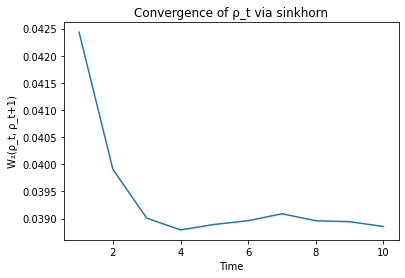

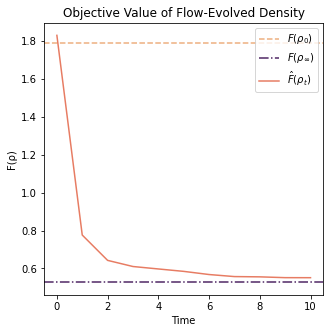

------------- FLOW WITH RANDOM RESTART # 8 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       8.67   1.06e+01     0.04     0.80   2.27e+00
 100       0.58   7.47e-01     0.04     0.06   1.39e-03
 200       0.56   7.49e-01     0.04     0.05   4.19e-04
 300       0.57   7.46e-01     0.04     0.04   2.38e-04
 400       0.57   7.43e-01     0.04     0.04   1.26e-04
 500       0.57   7.41e-01     0.04     0.04   3.08e-04
 600       0.57   7.43e-01     0.04     0.04   5.01e-04
 700       0.57   7.39e-01     0.04     0.04   1.37e-03
 800       0.57   7.41e-01     0.04     0.04   1.86e-04
 900       0.57   7.40e-01     0.04     0.04   3.07e-04
1000       0.57   7.40e-01     0.04     0.04   9.28e-05

---> After JKO Step: 1, F(ρ)=7.4061e-01 <---

inversion error 0.08135128021240234
F(ρₜ)=  1.4809 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖ 

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.0543520450592041
inversion error 0.05894184112548828
inversion error 0.023792266845703125
inversion error 0.10573911666870117
F(ρₜ)=  0.8261 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       0.43   8.78e-01     0.03     0.26   5.96e-01
 100       0.00   5.60e-01     0.03     0.03   1.14e-03
 200       0.00   5.52e-01     0.03     0.03   7.80e-04
 300       0.00   5.50e-01     0.03     0.04   2.50e-03
 400       0.00   5.49e-01     0.03     0.03   2.92e-04
 500       0.00   5.49e-01     0.03     0.03   5.50e-04
 600       0.00   5.48e-01     0.03     0.03   7.74e-04
 700       0.00   5.49e-01     0.03     0.03   1.85e-03
 800       0.00   5.49e-01     0.03     0.03   6.49e-04
 900       0.00   5.48e-01     0.03     0.03   3.45e-04
1000       0.00   5.48e-01     0.03     0.03   2.18e-04

---> After JKO Step: 6, F(ρ)=5.4875e

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.08759951591491699
inversion error 0.044327616691589355
inversion error 0.099312424659729
inversion error 0.02608644962310791
inversion error 0.02151632308959961
inversion error 0.054016947746276855
inversion error 0.09900808334350586
inversion error 0.04243803024291992
inversion error 0.08231234550476074
F(ρₜ)=  0.8214 (via exact computation)


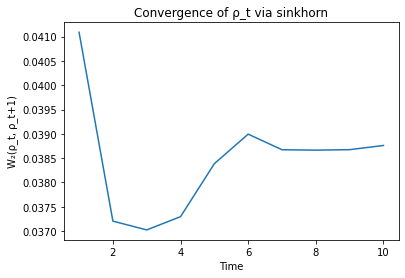

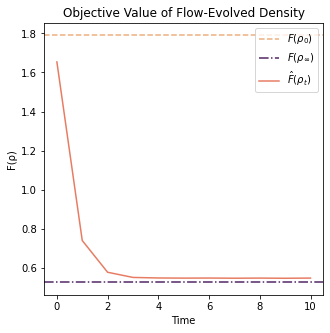

------------- FLOW WITH RANDOM RESTART # 9 -------------


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       3.85   7.24e+00     0.12     0.10   1.55e+00
 100       0.66   7.89e-01     0.12     0.01   3.65e-03
 200       0.64   7.81e-01     0.12     0.11   6.26e-04
 300       0.64   7.76e-01     0.12     0.11   2.37e-04
 400       0.64   7.75e-01     0.12     0.11   3.16e-04
 500       0.64   7.76e-01     0.12     0.11   4.13e-04
 600       0.65   7.74e-01     0.12     0.11   3.45e-04
 700       0.64   7.75e-01     0.12     0.12   4.27e-04
 800       0.64   7.73e-01     0.12     0.12   4.28e-04
 900       0.65   7.71e-01     0.12     0.12   3.62e-04
1000       0.65   7.67e-01     0.12     0.11   3.29e-04

---> After JKO Step: 1, F(ρ)=7.7041e-01 <---

inversion error 0.06515645980834961
F(ρₜ)=  1.2047 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖ 

../src/flow.py:261: RuntimeWarning: divide by zero encountered in log10
  ideal_range = np.array([np.floor(np.log10(self.τ/ratio)), np.ceil(np.log10(self.τ/ratio))])


 100       0.11   6.03e-01     0.11     0.09   2.46e-03
 200       0.11   5.96e-01     0.11     0.12   1.31e-03
 300       0.11   5.93e-01     0.11     0.12   1.41e-03
 400       0.11   5.88e-01     0.11     0.12   1.08e-03
 500       0.11   5.83e-01     0.11     0.12   1.01e-03
 600       0.11   5.83e-01     0.11     0.11   2.25e-04
 700       0.11   5.82e-01     0.11     0.11   5.50e-04
 800       0.11   5.80e-01     0.11     0.11   4.63e-04
 900       0.11   5.81e-01     0.11     0.12   4.46e-04
1000       0.11   5.81e-01     0.11     0.11   3.48e-04

---> After JKO Step: 2, F(ρ)=5.8075e-01 <---

inversion error 0.030759572982788086
inversion error 0.060044050216674805
F(ρₜ)=  0.8369 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       1.07   1.59e+00     0.11     0.38   8.43e-01
 100       0.01   5.62e-01     0.11     0.11   1.23e-03
 200

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.0497589111328125
inversion error 0.059736013412475586
inversion error 0.06105160713195801
inversion error 0.11228448152542114
F(ρₜ)=  0.6404 (via exact computation)
------------------------------------------------------
Iter   W(ρ,ρ_t) F(ρ)=𝒲(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
------------------------------------------------------
   0       1.41   7.79e-01     0.12     1.19   1.07e+00
 100       0.00   5.53e-01     0.12     0.12   1.08e-03
 200       0.00   5.50e-01     0.12     0.12   4.74e-04
 300       0.00   5.49e-01     0.12     0.12   4.20e-04
 400       0.00   5.48e-01     0.12     0.12   3.67e-04
 500       0.00   5.47e-01     0.12     0.12   2.10e-04
 600       0.00   5.49e-01     0.12     0.11   2.91e-04
 700       0.00   5.48e-01     0.12     0.12   5.39e-04
 800       0.00   5.48e-01     0.12     0.12   4.44e-04
 900       0.00   5.48e-01     0.12     0.12   4.91e-04
1000       0.00   5.48e-01     0.12     0.11   2.21e-03

---> After JKO Step: 6, F(ρ)=5.4818e

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


inversion error 0.04466533660888672
inversion error 0.05913519859313965
inversion error 0.0732576847076416
inversion error 0.047017574310302734
inversion error 0.05240917205810547
inversion error 0.04053926467895508
inversion error 0.03630685806274414
inversion error 0.027886629104614258
inversion error 0.09253787994384766
F(ρₜ)=  0.6979 (via exact computation)


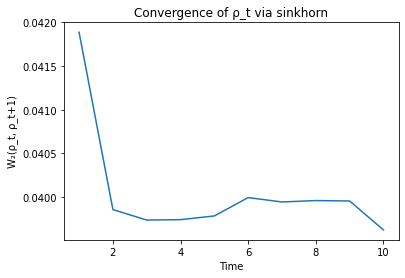

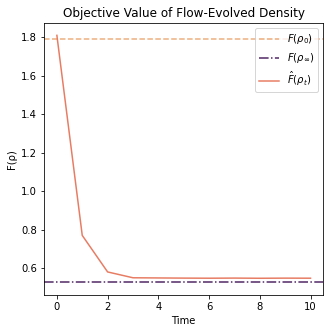

> /Users/daalvare/workspace/GFICNN/src/flow.py(514)flow_repeatedly()
-> F_exact_hist = feval_cb.F_exact_hist # this should be the same for all
(Pdb) l
509  	            F_estim_hist.append(feval_cb.F_estim_hist)
510  	            F_obj_hist.append(feval_cb.F_obj_hist)
511  	            times.append(feval_cb.times)
512  	
513  	        pdb.set_trace()
514  ->	        F_exact_hist = feval_cb.F_exact_hist # this should be the same for all
515  	
516  	        X_joint_hist  = torch.cat(X_joint_hist, dim = -1)  # n x d x t x reps
517  	        F_obj_hist = np.vstack(F_obj_hist)
518  	        F_estim_hist = np.vstack(F_estim_hist)
519  	        times         = np.vstack(times)
(Pdb) n
> /Users/daalvare/workspace/GFICNN/src/flow.py(516)flow_repeatedly()
-> X_joint_hist  = torch.cat(X_joint_hist, dim = -1)  # n x d x t x reps
(Pdb) n
> /Users/daalvare/workspace/GFICNN/src/flow.py(517)flow_repeatedly()
-> F_obj_hist = np.vstack(F_obj_hist)
(Pdb) n
> /Users/daalvare/workspace/GFICNN/src/flow.py(

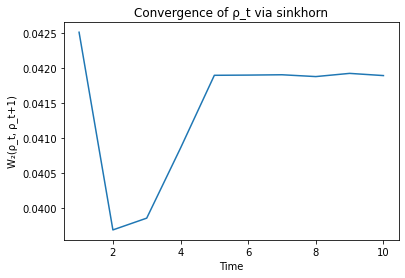

In [336]:
cb = CallbackList([cb1, cb2, cb3]) 

gf = GradFlow(X, F=F, ρ0=ρ0, τ=1e0, lr = 1e-3, strongify_icnn=1e-12, convex_net = factory,
              callbacks=cb, optimizer = 'adam', opt_iters=1000)

XT = gf.flow_repeatedly(samples=1000, steps=10, repetitions=10)

> /Users/daalvare/workspace/GFICNN/src/callbacks.py(787)plot()
-> df = pd.DataFrame(np.column_stack([self.times.flatten(), self.F_obj_hist.flatten()]), columns=['Time', 'F'])
(Pdb) c


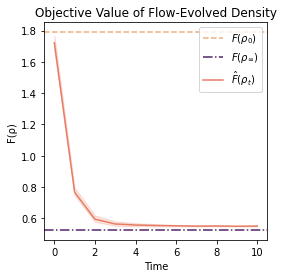

In [343]:
# #cb2.plot()
# H = cb2.F_estim_hist
# idx_delete = 4
# cb2.F_obj_hist = np.delete(cb2.F_obj_hist, idx_delete, 0)
# cb2.times = np.delete(cb2.times, idx_delete, 0)
# #cb2.plot()

# print(cb2.F_estim_hist)
# cb.F_estim_hist = cb2.F_obj_hist
# print(cb2.F_estim_hist)
# print(cb2.F_obj_hist)

#cb2.plot_F_estim = False

save_path = os.path.join(outdir, 'aggregation_F_convergence')
#save_path = None
cb2.save_path = save_path
cb2.figsize = (4,4)
cb2.plot(save_path=save_path)



../out/craig_pdes/aggregation_averaged_τ_1.0


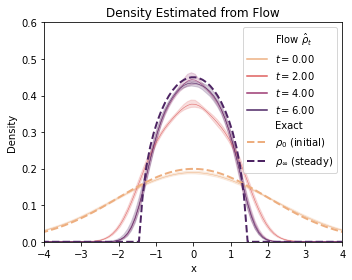

In [352]:
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

import src.utils
importlib.reload(src.utils)

from src.utils import averaged_density_plot

save_path = os.path.join(outdir, f'aggregation_averaged_τ_{gf.τ}')
print(save_path)
#save_path = None
averaged_density_plot(XT[:,:,:8,:],ρ0=ρ0, ρinf=ρinf, step_size = gf.τ, freq = 2, figsize=(5,4), domain=(-10,10),
                      xrng=(-4,4), yrng=(0,0.6), npoints=200, bw=0.4, 
                      title='Density Estimated from Flow',
                      save_path=save_path)

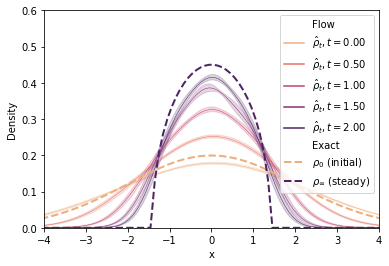

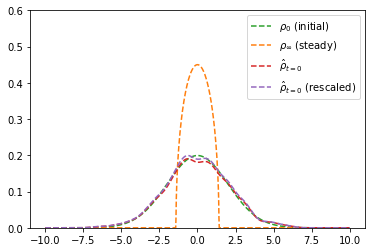

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


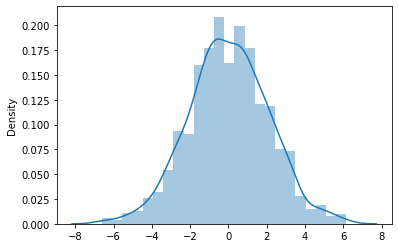

In [431]:
### Checking density scaling / rescaling / choice of bandwith


X_i[0].shape
x = torch.linspace(-10, 10, 1000)#.unsqueeze(1)

kde = sp.stats.gaussian_kde(X_i[0].flatten(), bw_method = 0.2)
z = kde(x.flatten())


scaler = torch.exp(ρ0.log_prob(x)).max().numpy() /  z.max() 

fig, ax = plt.subplots()
ax.plot(x, torch.exp(ρ0.log_prob(x)), label = r'$\rho_0$ (initial)', color='C2', ls='--')
ax.plot(x, torch.exp(ρinf.log_prob(x)), label = r'$\rho_{\infty}$ (steady)', color='C1', ls='--')
ax.plot(x, z, label = r'$\hat{\rho}_{t=0}$', color='C3', ls='--')
ax.plot(x, scaler*z, label = r'$\hat{\rho}_{t=0}$ (rescaled)', color='C4', ls='--')
ax.set_ylim(0,0.6)
plt.legend()
plt.show()


In [22]:
HTML(cb1.animation.to_html5_video())

In [298]:
HTML(cb1.animation.to_html5_video())

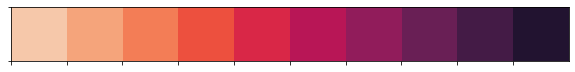

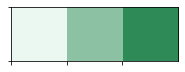

In [39]:
import seaborn as sns
sns.palplot(sns.color_palette("rocket", 10)[::-1])#, as_cmap=True)
sns.palplot(sns.light_palette("seagreen",3))


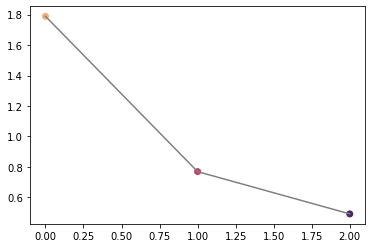

In [137]:
fig, ax = plt.subplots()
cm = plt.get_cmap('flare')

NPOINTS = 100
#ax.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])

ax.plot(cb2.times, cb2.F_estim_hist, c='gray')#, color = cb2.times)
ax.scatter(cb2.times, cb2.F_estim_hist, c = cb2.times, cmap='flare')
plt.show()